In [2]:
import pandas as pd
import numpy as np
from helpers.helper import *

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import seaborn as sns


pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('data/sales_prices_events_merge.csv', sep = ';', encoding = 'utf-8')

In [4]:
df.head()

,id,yearweek,item,category,department,store,store_code,region,year,event,value_sales,sell_price,avg_price_week,sell_price_new,avg_price_week_new
0,ACCESORIES_1_001_BOS_1,201328,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2013,NoEvent,0,12.7414,0.00000,"12,7414","0,0"
1,ACCESORIES_1_001_BOS_1,201329,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2013,NoEvent,4,10.9858,2.74645,"10,9858","2,74645"
2,ACCESORIES_1_001_BOS_1,201330,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2013,NoEvent,4,10.9858,2.74645,"10,9858","2,74645"
3,ACCESORIES_1_001_BOS_1,201331,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2013,NoEvent,2,10.9858,5.49290,"10,9858","5,4929"
4,ACCESORIES_1_001_BOS_1,201332,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2013,NoEvent,1,10.9858,10.98580,"10,9858","10,9858"


In [5]:
del df['sell_price_new']
del df['avg_price_week_new']

In [6]:
df.head()

,id,yearweek,item,category,department,store,store_code,region,year,event,value_sales,sell_price,avg_price_week
0,ACCESORIES_1_001_BOS_1,201328,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2013,NoEvent,0,12.7414,0.00000
1,ACCESORIES_1_001_BOS_1,201329,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2013,NoEvent,4,10.9858,2.74645
2,ACCESORIES_1_001_BOS_1,201330,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2013,NoEvent,4,10.9858,2.74645
3,ACCESORIES_1_001_BOS_1,201331,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2013,NoEvent,2,10.9858,5.49290
4,ACCESORIES_1_001_BOS_1,201332,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2013,NoEvent,1,10.9858,10.98580


In [7]:
# Codificação de variáveis categóricas
label_encoders = {}
for column in ['item', 'category']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [8]:
# Normalização de dados
scaler = StandardScaler()
df[['value_sales', 'avg_price_week']] = scaler.fit_transform(df[['value_sales', 'avg_price_week']])

In [9]:
# Seleção de features relevantes para clustering
X = df[['item', 'category', 'value_sales', 'avg_price_week']]

In [10]:
import random
def find_centroids(X, model_labels, n_clusters = 5, epsilon = 0.0001):
    # Function that gets the minimums and maximums from input features, and computes a random centroid.
    def get_random_centroid(mm):
        n_f = mm.shape[1]
        centroids = np.ones((n_f))
        
        for i in np.arange(n_f):
            centroids[i] = random.uniform(mm[0,i], mm[1,i])
            
        return centroids
        
    # meta data from the dataset
    n_features = X.shape[1]
    min_max = np.ones((5,n_features))

    # Find all mins and maxs for each feature so one can calculate random position of centroids
    for i in np.arange(n_features):
        min_max[0,i] = min(X[:,i])
        min_max[1,i] = max(X[:,i])

    # calculating the first centroids
    centroids = np.ones((n_clusters,n_features))
    for i in np.arange(n_clusters):
        centroids[i] = get_random_centroid(min_max)

    plt.scatter(X[:,0], X[:,1], c=model_labels, marker=".")
    plt.scatter(centroids[:,0], centroids[:,1], c="red")
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.show()

    return centroids

from scipy.spatial import distance

def find_cluster_sample(X, model_labels, centroids, n_clusters, epsilon):
    # buffer of centroids
    old_centroids = centroids
    cluster_dist = 9999

    # until the distance between previous and new centroids is below epsilon
    while cluster_dist > epsilon:
        
        # final cluster per sample
        clustering_vals = np.ones(X.shape[0])

        # for all points, calculate the distance towards each centroid
        for i in np.arange(X.shape[0]):
            temp_dst = 9999
            c_index = -1
            # for all clusters
            for c in np.arange(n_clusters):
                dst = distance.euclidean(centroids[c], X[i])
                if dst < temp_dst:
                    temp_dst = dst
                    c_index = c

            clustering_vals[i] = c_index

        ###################################################################################
        plt.scatter(X[:,0], X[:,1], c=clustering_vals, marker=".")
        plt.scatter(centroids[:,0], centroids[:,1], c="green")
        plt.scatter(old_centroids[:,0], old_centroids[:,1], c="red")
        for c in np.arange(n_clusters):
            plt.plot([old_centroids[c,0], centroids[c,0]],[old_centroids[c,1], centroids[c,1]],'r')
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.show()
        ###################################################################################
        
        old_centroids = centroids.copy()
        
        for c in np.arange(n_clusters):
            # filter samples per cluster
            filt_samples = X[np.where(clustering_vals == c),:][0]
            # calculate the mean value for all samples in a cluster
            result = np.sum(filt_samples, axis=0) / filt_samples.shape[0]
            # update cluster
            centroids[c] = result

        print("old_centroids:" , old_centroids)
        print("centroids:", centroids)
        
        # calculate distances between previous and next centroids
        cluster_dist = np.sum([distance.euclidean(centroids[c], old_centroids[c]) for c in np.arange(n_clusters)])
        print("cluster distances:" , cluster_dist)
        
    ###################################################################################
    print("Converged to a final solution")
    plt.scatter(X[:,0], X[:,1], c=clustering_vals, marker=".")
    plt.scatter(centroids[:,0], centroids[:,1], c="red")
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.show()


    print("True labels")
    plt.scatter(X[:,0], X[:,1], c=model_labels, marker=".")
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.show()

# KMeans

In [11]:
# Algoritmo de clustering (K-means)
kmeans = KMeans(n_clusters=5) 
kmeans.fit(X)
df['cluster'] = kmeans.labels_

In [12]:
print(df[['item', 'category', 'cluster']])

         item  category  cluster
0           0         0        0
1           0         0        0
2           0         0        0
3           0         0        0
4           0         0        0
...       ...       ...      ...
6544812  3048         2        3
6544813  3048         2        3
6544814  3048         2        3
6544815  3048         2        3
6544816  3048         2        3

[6544817 rows x 3 columns]


In [13]:
df['cluster'].value_counts()

4    1395742
0    1375686
2    1322943
3    1237592
1    1212854
Name: cluster, dtype: int64

In [14]:
pca = PCA(n_components=2)

In [15]:
# Construindo o pipeline
pipeline = make_pipeline(scaler, pca, kmeans)

In [16]:
# Ajustando o modelo
pipeline.fit(df[['item', 'category', 'value_sales', 'avg_price_week']])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=5))])

In [17]:
# Obtendo as coordenadas dos clusters
pca_features = pca.transform(df[['item', 'category', 'value_sales', 'avg_price_week']])
df['x'] = pca_features[:, 0]
df['y'] = pca_features[:, 1]

c:\Users\josiv\Desktop\Nuclio_VS\NDS\DCTP\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [18]:
pca_features

array([[ 6.64272647e-02, -1.51800401e-02],
       [-1.95061220e-01, -4.20968350e-01],
       [-1.95061220e-01, -4.20968350e-01],
       ...,
       [ 1.99077511e+03, -7.93406998e+02],
       [ 1.99071894e+03, -7.93611000e+02],
       [ 1.99071894e+03, -7.93611000e+02]])

In [19]:
print(df['x'].head())
print(df['y'].head())

0    0.066427
1   -0.195061
2   -0.195061
3   -0.510868
4   -1.115322
Name: x, dtype: float64
0   -0.015180
1   -0.420968
2   -0.420968
3   -1.001142
4   -2.074296
Name: y, dtype: float64


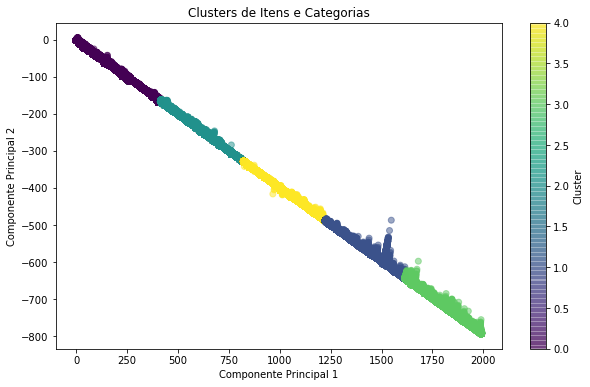

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters de Itens e Categorias')
plt.colorbar(label='Cluster')
plt.show()

In [22]:
X['label'] = kmeans.labels_

C:\Users\josiv\AppData\Local\Temp\ipykernel_17876\1546010253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['label'] = kmeans.labels_


In [23]:
for i in range(5):
    print(f'Cluster : {i}')
    print(X[X.label == i].describe().iloc[[0, 1, 3, 7], :-1])
    print('\n\n')

Cluster : 0
               item   category   value_sales  avg_price_week
count  2.948001e+06  2948001.0  2.948001e+06    2.948001e+06
mean   2.325290e+03        2.0  2.708561e-02   -2.704510e-01
min    1.612000e+03        2.0 -3.794080e-01   -5.208571e-01
max    3.048000e+03        2.0  3.117044e+00    3.359083e+00



Cluster : 1
               item   category   value_sales  avg_price_week
count  1.122285e+06  1122285.0  1.122285e+06    1.122285e+06
mean   2.832856e+02        0.0 -1.826986e-01   -5.607313e-02
min    0.000000e+00        0.0 -3.794080e-01   -5.208571e-01
max    5.640000e+02        0.0  4.219187e+00    2.349499e+00



Cluster : 2
                item      category    value_sales  avg_price_week
count  361373.000000  361373.00000  361373.000000   361373.000000
mean      959.988339       0.76291      -0.333147        3.206364
min         0.000000       0.00000      -0.341403        1.342422
max      2914.000000       2.00000      -0.151378       47.780368



Cluster : 3
   

## Segmentação de Dados

In [24]:
X_segmentacao = np.array(X)

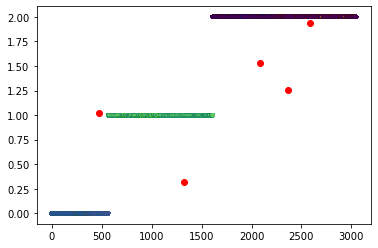

In [26]:
n_clusters = 5
epsilon = 0.0001
centroids = find_centroids(X_segmentacao, kmeans.labels_, n_clusters, epsilon)

## Encontrar Clusters

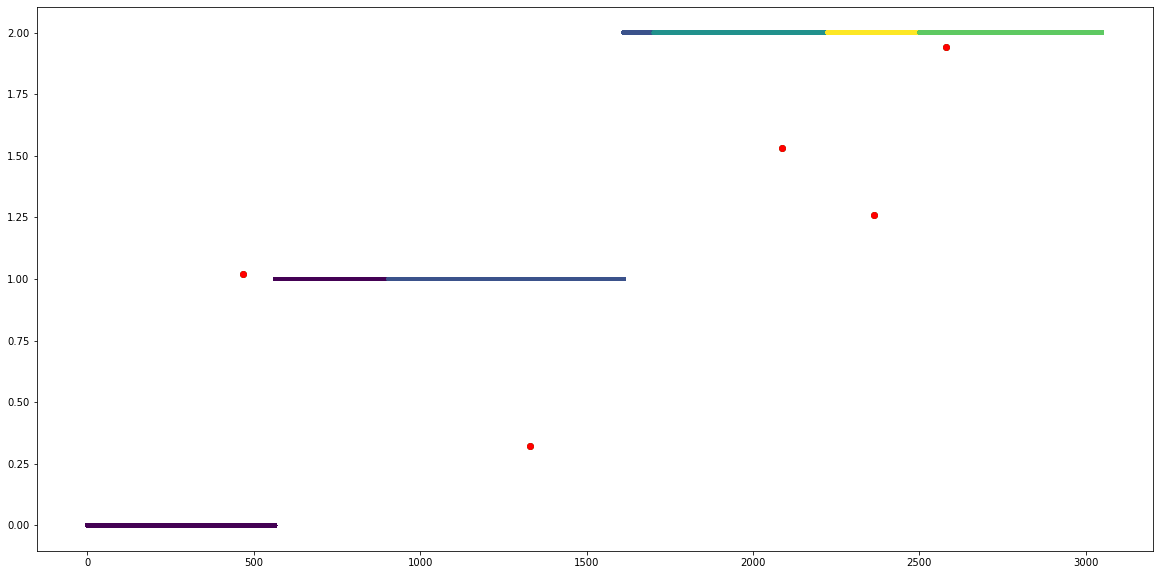

old_centroids: [[4.68420508e+02 1.02163458e+00 9.87750749e+00 2.21550374e+01
  2.78902793e-01]
 [1.32871766e+03 3.21951678e-01 9.34068009e+01 4.12244433e+01
  2.18585089e+00]
 [2.08585762e+03 1.53236635e+00 3.92806954e+01 2.06502195e+01
  3.25478296e+00]
 [2.58093903e+03 1.94099457e+00 1.07726831e+02 4.22513560e+01
  2.59460290e+00]
 [2.36402604e+03 1.25913393e+00 3.32119603e+01 3.59173557e+00
  3.53714373e+00]]
centroids: [[ 4.44430519e+02  3.65664134e-01 -1.24283325e-01  1.87174234e-01
   1.76565391e+00]
 [ 1.31069536e+03  1.12015992e+00 -1.70392413e-01  2.01954005e-01
   2.54482914e+00]
 [ 1.95567477e+03  2.00000000e+00 -1.43025999e-02 -1.72352135e-01
   5.96101535e-02]
 [ 2.77346496e+03  2.00000000e+00  3.39644842e-01 -3.12920832e-01
   1.57192998e-01]
 [ 2.36406279e+03  2.00000000e+00  2.74038295e-01 -2.90773049e-01
   1.23127231e-01]]
cluster distances: 533.3165772260014


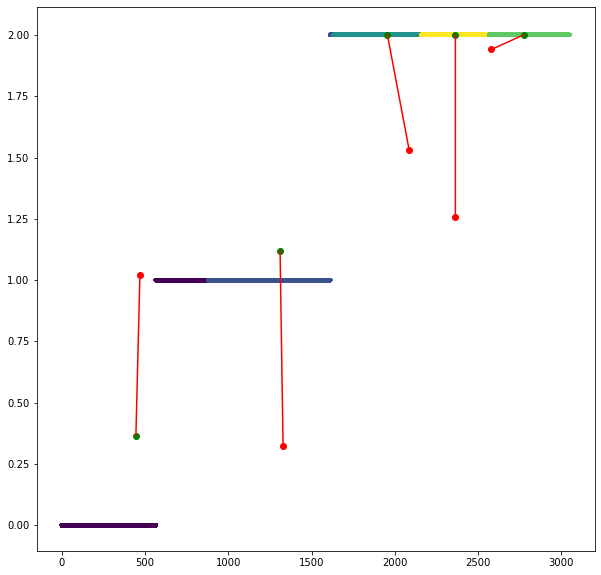

old_centroids: [[ 4.44430519e+02  3.65664134e-01 -1.24283325e-01  1.87174234e-01
   1.76565391e+00]
 [ 1.31069536e+03  1.12015992e+00 -1.70392413e-01  2.01954005e-01
   2.54482914e+00]
 [ 1.95567477e+03  2.00000000e+00 -1.43025999e-02 -1.72352135e-01
   5.96101535e-02]
 [ 2.77346496e+03  2.00000000e+00  3.39644842e-01 -3.12920832e-01
   1.57192998e-01]
 [ 2.36406279e+03  2.00000000e+00  2.74038295e-01 -2.90773049e-01
   1.23127231e-01]]
centroids: [[ 4.30604055e+02  3.46031513e-01 -1.31841981e-01  1.93755200e-01
   1.72913317e+00]
 [ 1.26198809e+03  1.03176867e+00 -1.77640368e-01  2.31865402e-01
   2.79547283e+00]
 [ 1.88664430e+03  2.00000000e+00 -1.52315476e-02 -1.74326859e-01
   5.97897915e-02]
 [ 2.80824516e+03  2.00000000e+00  3.38555197e-01 -3.15160994e-01
   1.55773311e-01]
 [ 2.36805101e+03  2.00000000e+00  2.50116867e-01 -2.75856043e-01
   1.23380316e-01]]
cluster distances: 170.33353162018358


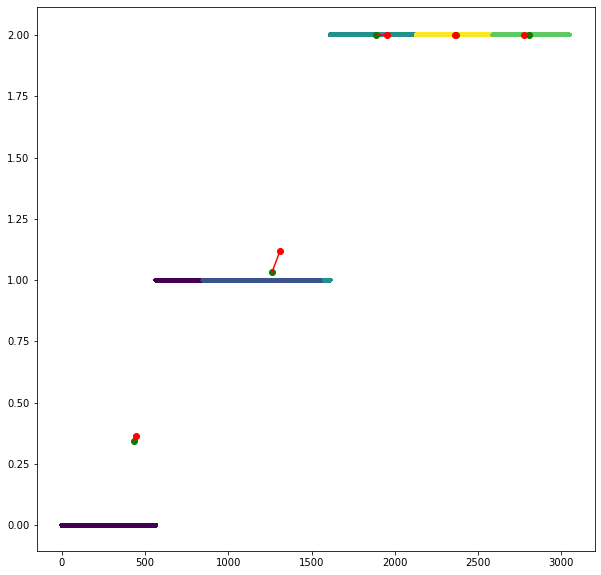

old_centroids: [[ 4.30604055e+02  3.46031513e-01 -1.31841981e-01  1.93755200e-01
   1.72913317e+00]
 [ 1.26198809e+03  1.03176867e+00 -1.77640368e-01  2.31865402e-01
   2.79547283e+00]
 [ 1.88664430e+03  2.00000000e+00 -1.52315476e-02 -1.74326859e-01
   5.97897915e-02]
 [ 2.80824516e+03  2.00000000e+00  3.38555197e-01 -3.15160994e-01
   1.55773311e-01]
 [ 2.36805101e+03  2.00000000e+00  2.50116867e-01 -2.75856043e-01
   1.23380316e-01]]
centroids: [[ 4.16141590e+02  3.24090691e-01 -1.37175597e-01  2.01506923e-01
   1.68818926e+00]
 [ 1.21768229e+03  1.00000000e+00 -1.73714090e-01  2.25394243e-01
   2.88897519e+00]
 [ 1.83880198e+03  1.92933509e+00 -2.93811838e-02 -1.35726375e-01
   2.56971306e-01]
 [ 2.81816655e+03  2.00000000e+00  3.40624382e-01 -3.13279955e-01
   1.57463877e-01]
 [ 2.36135292e+03  2.00000000e+00  2.33899072e-01 -2.68203134e-01
   1.19457898e-01]]
cluster distances: 123.23074355991767


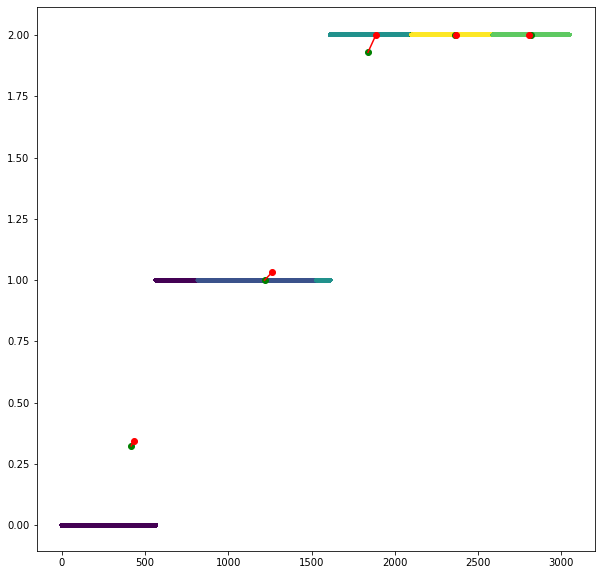

old_centroids: [[ 4.16141590e+02  3.24090691e-01 -1.37175597e-01  2.01506923e-01
   1.68818926e+00]
 [ 1.21768229e+03  1.00000000e+00 -1.73714090e-01  2.25394243e-01
   2.88897519e+00]
 [ 1.83880198e+03  1.92933509e+00 -2.93811838e-02 -1.35726375e-01
   2.56971306e-01]
 [ 2.81816655e+03  2.00000000e+00  3.40624382e-01 -3.13279955e-01
   1.57463877e-01]
 [ 2.36135292e+03  2.00000000e+00  2.33899072e-01 -2.68203134e-01
   1.19457898e-01]]
centroids: [[ 4.02202120e+02  3.01419653e-01 -1.39547070e-01  2.01750954e-01
   1.64717917e+00]
 [ 1.17971189e+03  1.00000000e+00 -1.62861763e-01  2.14392881e-01
   2.89159197e+00]
 [ 1.80134528e+03  1.84392588e+00 -5.47383113e-02 -8.97438742e-02
   4.96187760e-01]
 [ 2.81870533e+03  2.00000000e+00  3.42014465e-01 -3.14360385e-01
   1.57834078e-01]
 [ 2.34909700e+03  2.00000000e+00  2.23972189e-01 -2.62284371e-01
   1.16450783e-01]]
cluster distances: 102.162267055518


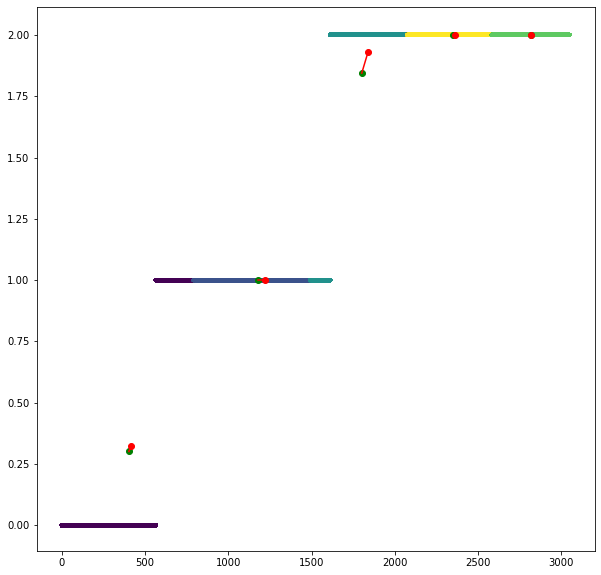

old_centroids: [[ 4.02202120e+02  3.01419653e-01 -1.39547070e-01  2.01750954e-01
   1.64717917e+00]
 [ 1.17971189e+03  1.00000000e+00 -1.62861763e-01  2.14392881e-01
   2.89159197e+00]
 [ 1.80134528e+03  1.84392588e+00 -5.47383113e-02 -8.97438742e-02
   4.96187760e-01]
 [ 2.81870533e+03  2.00000000e+00  3.42014465e-01 -3.14360385e-01
   1.57834078e-01]
 [ 2.34909700e+03  2.00000000e+00  2.23972189e-01 -2.62284371e-01
   1.16450783e-01]]
centroids: [[ 3.91137744e+02  2.82162655e-01 -1.45153993e-01  2.08242507e-01
   1.61143361e+00]
 [ 1.15019626e+03  1.00000000e+00 -1.49508186e-01  2.04127220e-01
   2.89399085e+00]
 [ 1.77264989e+03  1.78396816e+00 -6.63207892e-02 -6.68244008e-02
   6.66026337e-01]
 [ 2.81587444e+03  2.00000000e+00  3.43356384e-01 -3.14074600e-01
   1.58712472e-01]
 [ 2.33569660e+03  2.00000000e+00  2.06384237e-01 -2.55100003e-01
   1.11870106e-01]]
cluster distances: 85.50735971597605


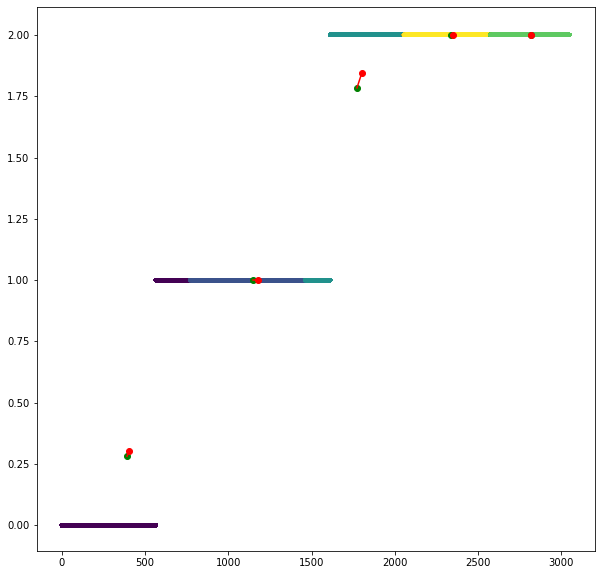

old_centroids: [[ 3.91137744e+02  2.82162655e-01 -1.45153993e-01  2.08242507e-01
   1.61143361e+00]
 [ 1.15019626e+03  1.00000000e+00 -1.49508186e-01  2.04127220e-01
   2.89399085e+00]
 [ 1.77264989e+03  1.78396816e+00 -6.63207892e-02 -6.68244008e-02
   6.66026337e-01]
 [ 2.81587444e+03  2.00000000e+00  3.43356384e-01 -3.14074600e-01
   1.58712472e-01]
 [ 2.33569660e+03  2.00000000e+00  2.06384237e-01 -2.55100003e-01
   1.11870106e-01]]
centroids: [[ 3.81949613e+02  2.65232227e-01 -1.46385275e-01  2.12402326e-01
   1.58018754e+00]
 [ 1.12544174e+03  1.00000000e+00 -1.42366528e-01  1.95009856e-01
   2.89645527e+00]
 [ 1.74676177e+03  1.73481246e+00 -8.07787655e-02 -4.04686417e-02
   8.04037891e-01]
 [ 2.81223573e+03  2.00000000e+00  3.36645087e-01 -3.13065851e-01
   1.56458346e-01]
 [ 2.32111422e+03  2.00000000e+00  2.03608349e-01 -2.55382038e-01
   1.10988811e-01]]
cluster distances: 78.0523651929756


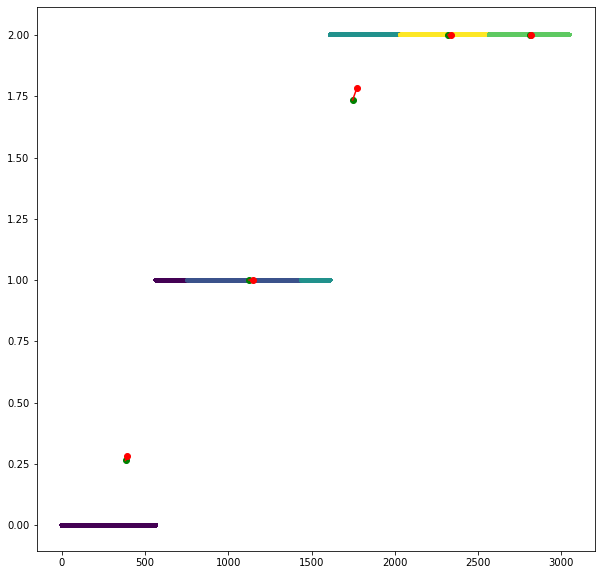

old_centroids: [[ 3.81949613e+02  2.65232227e-01 -1.46385275e-01  2.12402326e-01
   1.58018754e+00]
 [ 1.12544174e+03  1.00000000e+00 -1.42366528e-01  1.95009856e-01
   2.89645527e+00]
 [ 1.74676177e+03  1.73481246e+00 -8.07787655e-02 -4.04686417e-02
   8.04037891e-01]
 [ 2.81223573e+03  2.00000000e+00  3.36645087e-01 -3.13065851e-01
   1.56458346e-01]
 [ 2.32111422e+03  2.00000000e+00  2.03608349e-01 -2.55382038e-01
   1.10988811e-01]]
centroids: [[ 3.73605295e+02  2.49082217e-01 -1.49021941e-01  2.19627793e-01
   1.55007662e+00]
 [ 1.10456231e+03  1.00000000e+00 -1.35578755e-01  1.83486736e-01
   2.89901459e+00]
 [ 1.72523276e+03  1.69599857e+00 -8.64863758e-02 -2.25996262e-02
   9.13912168e-01]
 [ 2.80737262e+03  2.00000000e+00  3.36535004e-01 -3.14173305e-01
   1.55209063e-01]
 [ 2.30655470e+03  2.00000000e+00  1.89498521e-01 -2.49832925e-01
   1.08188811e-01]]
cluster distances: 70.1758004592915


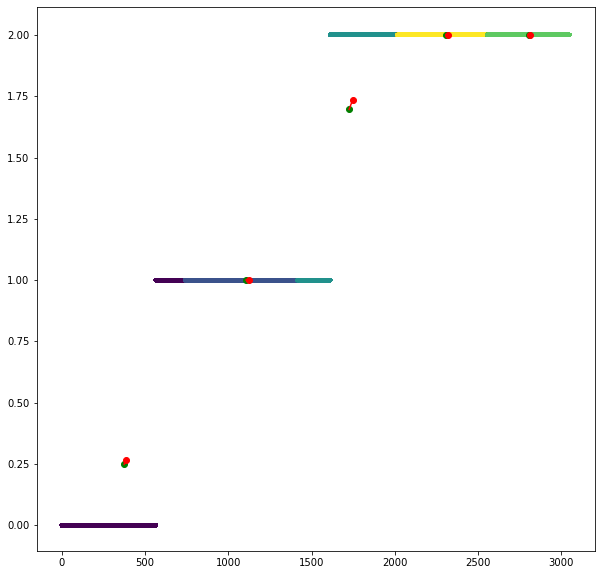

old_centroids: [[ 3.73605295e+02  2.49082217e-01 -1.49021941e-01  2.19627793e-01
   1.55007662e+00]
 [ 1.10456231e+03  1.00000000e+00 -1.35578755e-01  1.83486736e-01
   2.89901459e+00]
 [ 1.72523276e+03  1.69599857e+00 -8.64863758e-02 -2.25996262e-02
   9.13912168e-01]
 [ 2.80737262e+03  2.00000000e+00  3.36535004e-01 -3.14173305e-01
   1.55209063e-01]
 [ 2.30655470e+03  2.00000000e+00  1.89498521e-01 -2.49832925e-01
   1.08188811e-01]]
centroids: [[ 3.66695613e+02  2.35156097e-01 -1.50291749e-01  2.25720498e-01
   1.52395451e+00]
 [ 1.08640647e+03  1.00000000e+00 -1.29328899e-01  1.70591606e-01
   2.90157425e+00]
 [ 1.70578785e+03  1.66170911e+00 -9.82139171e-02 -3.96709849e-03
   1.00914516e+00]
 [ 2.80287388e+03  2.00000000e+00  3.31322523e-01 -3.13985465e-01
   1.52760266e-01]
 [ 2.29309627e+03  2.00000000e+00  1.87870222e-01 -2.45490677e-01
   1.08952615e-01]]
cluster distances: 62.46795241189244


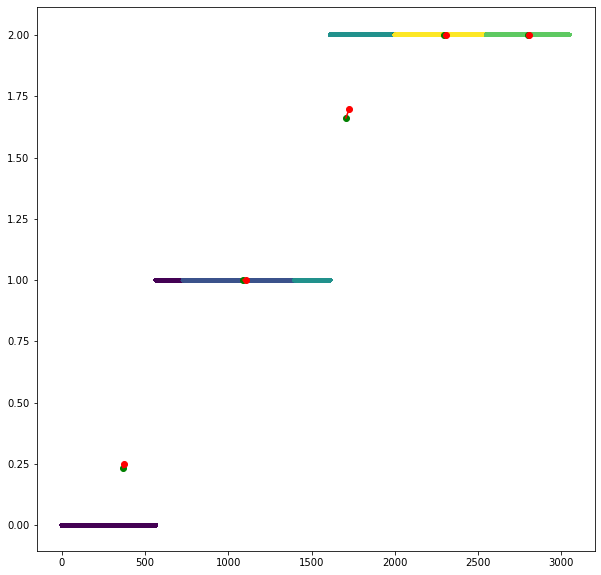

old_centroids: [[ 3.66695613e+02  2.35156097e-01 -1.50291749e-01  2.25720498e-01
   1.52395451e+00]
 [ 1.08640647e+03  1.00000000e+00 -1.29328899e-01  1.70591606e-01
   2.90157425e+00]
 [ 1.70578785e+03  1.66170911e+00 -9.82139171e-02 -3.96709849e-03
   1.00914516e+00]
 [ 2.80287388e+03  2.00000000e+00  3.31322523e-01 -3.13985465e-01
   1.52760266e-01]
 [ 2.29309627e+03  2.00000000e+00  1.87870222e-01 -2.45490677e-01
   1.08952615e-01]]
centroids: [[ 3.59752031e+02  2.20676504e-01 -1.54605550e-01  2.33698425e-01
   1.49644905e+00]
 [ 1.07083686e+03  1.00000000e+00 -1.20637180e-01  1.63659867e-01
   2.90295624e+00]
 [ 1.69025524e+03  1.63508669e+00 -1.08194576e-01  6.26122395e-03
   1.08500070e+00]
 [ 2.79774647e+03  2.00000000e+00  3.32866658e-01 -3.15225710e-01
   1.53004881e-01]
 [ 2.28038268e+03  2.00000000e+00  1.80889793e-01 -2.43431113e-01
   1.06608888e-01]]
cluster distances: 55.88710679413321


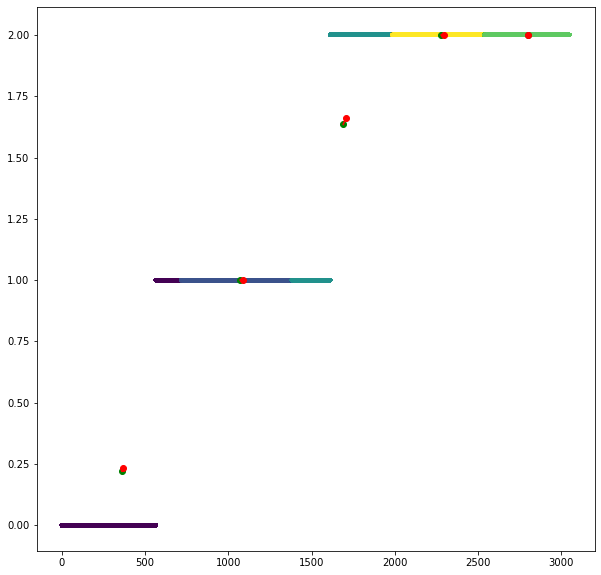

old_centroids: [[ 3.59752031e+02  2.20676504e-01 -1.54605550e-01  2.33698425e-01
   1.49644905e+00]
 [ 1.07083686e+03  1.00000000e+00 -1.20637180e-01  1.63659867e-01
   2.90295624e+00]
 [ 1.69025524e+03  1.63508669e+00 -1.08194576e-01  6.26122395e-03
   1.08500070e+00]
 [ 2.79774647e+03  2.00000000e+00  3.32866658e-01 -3.15225710e-01
   1.53004881e-01]
 [ 2.28038268e+03  2.00000000e+00  1.80889793e-01 -2.43431113e-01
   1.06608888e-01]]
centroids: [[ 3.55055108e+02  2.10551200e-01 -1.54421525e-01  2.33374026e-01
   1.47845987e+00]
 [ 1.05769276e+03  1.00000000e+00 -1.18005968e-01  1.61744029e-01
   2.90382597e+00]
 [ 1.67528575e+03  1.60951248e+00 -1.13073334e-01  1.72743043e-02
   1.15716560e+00]
 [ 2.79361722e+03  2.00000000e+00  3.41532210e-01 -3.16932394e-01
   1.57177348e-01]
 [ 2.26903216e+03  2.00000000e+00  1.64140486e-01 -2.38024212e-01
   1.00004272e-01]]
cluster distances: 48.29055642902205


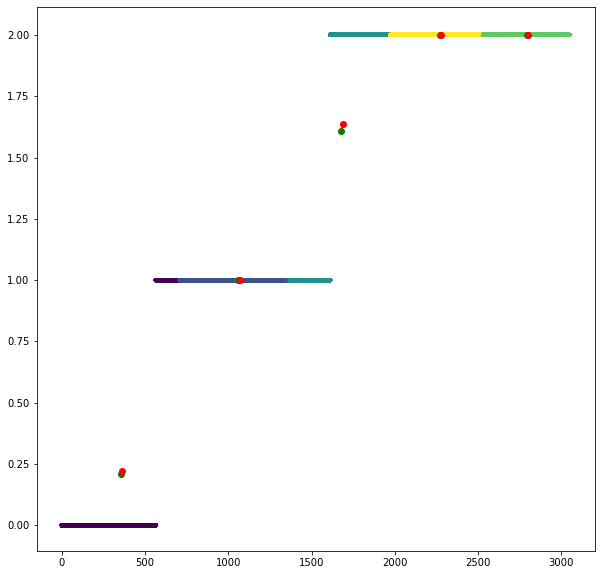

old_centroids: [[ 3.55055108e+02  2.10551200e-01 -1.54421525e-01  2.33374026e-01
   1.47845987e+00]
 [ 1.05769276e+03  1.00000000e+00 -1.18005968e-01  1.61744029e-01
   2.90382597e+00]
 [ 1.67528575e+03  1.60951248e+00 -1.13073334e-01  1.72743043e-02
   1.15716560e+00]
 [ 2.79361722e+03  2.00000000e+00  3.41532210e-01 -3.16932394e-01
   1.57177348e-01]
 [ 2.26903216e+03  2.00000000e+00  1.64140486e-01 -2.38024212e-01
   1.00004272e-01]]
centroids: [[ 3.50704628e+02  2.00900982e-01 -1.57210371e-01  2.36318125e-01
   1.46070915e+00]
 [ 1.04572783e+03  1.00000000e+00 -1.11097418e-01  1.56587265e-01
   2.90568077e+00]
 [ 1.66240675e+03  1.58749823e+00 -1.19737845e-01  2.68984110e-02
   1.21848968e+00]
 [ 2.78919503e+03  2.00000000e+00  3.36431201e-01 -3.17033458e-01
   1.55274425e-01]
 [ 2.25858404e+03  2.00000000e+00  1.62568600e-01 -2.34777843e-01
   9.98021837e-02]]
cluster distances: 44.064942669687575


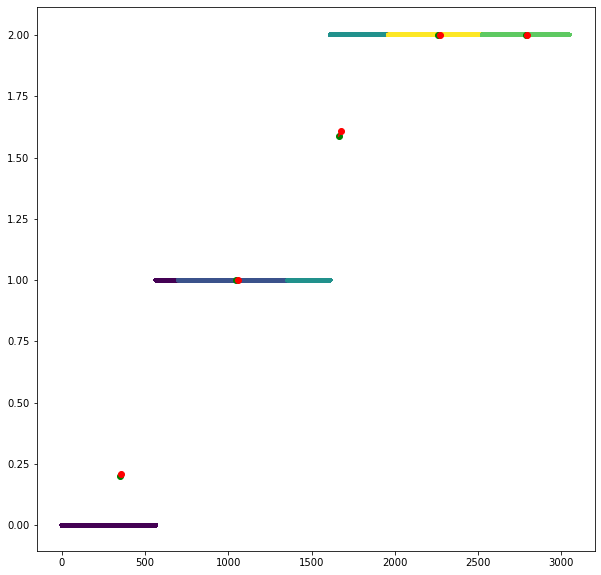

old_centroids: [[ 3.50704628e+02  2.00900982e-01 -1.57210371e-01  2.36318125e-01
   1.46070915e+00]
 [ 1.04572783e+03  1.00000000e+00 -1.11097418e-01  1.56587265e-01
   2.90568077e+00]
 [ 1.66240675e+03  1.58749823e+00 -1.19737845e-01  2.68984110e-02
   1.21848968e+00]
 [ 2.78919503e+03  2.00000000e+00  3.36431201e-01 -3.17033458e-01
   1.55274425e-01]
 [ 2.25858404e+03  2.00000000e+00  1.62568600e-01 -2.34777843e-01
   9.98021837e-02]]
centroids: [[ 3.46459932e+02  1.91265864e-01 -1.57937141e-01  2.40288076e-01
   1.44278358e+00]
 [ 1.03516699e+03  1.00000000e+00 -1.07328139e-01  1.49707245e-01
   2.90764516e+00]
 [ 1.65055986e+03  1.56781245e+00 -1.24046462e-01  3.92643146e-02
   1.27404983e+00]
 [ 2.78470564e+03  2.00000000e+00  3.33505429e-01 -3.18097997e-01
   1.52633893e-01]
 [ 2.24773408e+03  2.00000000e+00  1.57193360e-01 -2.33534008e-01
   9.94068677e-02]]
cluster distances: 41.99199110443709


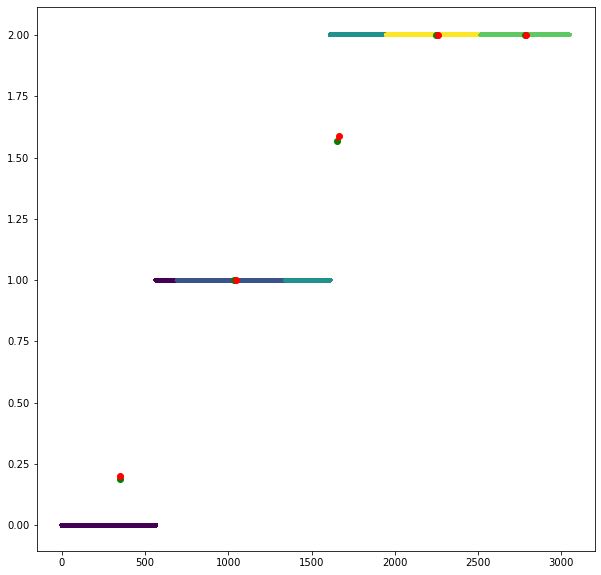

old_centroids: [[ 3.46459932e+02  1.91265864e-01 -1.57937141e-01  2.40288076e-01
   1.44278358e+00]
 [ 1.03516699e+03  1.00000000e+00 -1.07328139e-01  1.49707245e-01
   2.90764516e+00]
 [ 1.65055986e+03  1.56781245e+00 -1.24046462e-01  3.92643146e-02
   1.27404983e+00]
 [ 2.78470564e+03  2.00000000e+00  3.33505429e-01 -3.18097997e-01
   1.52633893e-01]
 [ 2.24773408e+03  2.00000000e+00  1.57193360e-01 -2.33534008e-01
   9.94068677e-02]]
centroids: [[ 3.42777206e+02  1.82713033e-01 -1.58253061e-01  2.44303465e-01
   1.42665429e+00]
 [ 1.02476451e+03  1.00000000e+00 -1.03581399e-01  1.40527738e-01
   2.90966134e+00]
 [ 1.63917985e+03  1.54866724e+00 -1.30676329e-01  4.91825686e-02
   1.32519366e+00]
 [ 2.78136924e+03  2.00000000e+00  3.33828261e-01 -3.13153718e-01
   1.54627209e-01]
 [ 2.23893757e+03  2.00000000e+00  1.52790179e-01 -2.33950947e-01
   9.84893596e-02]]
cluster distances: 37.598322316751876


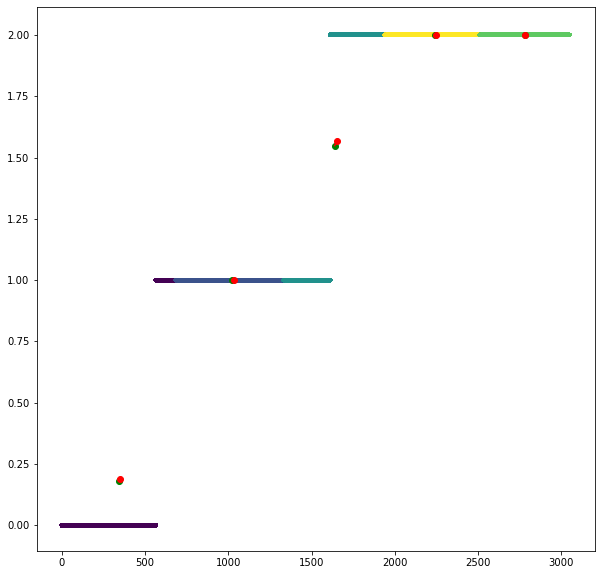

old_centroids: [[ 3.42777206e+02  1.82713033e-01 -1.58253061e-01  2.44303465e-01
   1.42665429e+00]
 [ 1.02476451e+03  1.00000000e+00 -1.03581399e-01  1.40527738e-01
   2.90966134e+00]
 [ 1.63917985e+03  1.54866724e+00 -1.30676329e-01  4.91825686e-02
   1.32519366e+00]
 [ 2.78136924e+03  2.00000000e+00  3.33828261e-01 -3.13153718e-01
   1.54627209e-01]
 [ 2.23893757e+03  2.00000000e+00  1.52790179e-01 -2.33950947e-01
   9.84893596e-02]]
centroids: [[ 3.38814614e+02  1.73301115e-01 -1.58975396e-01  2.46335174e-01
   1.40949955e+00]
 [ 1.01426241e+03  1.00000000e+00 -9.97543307e-02  1.35697702e-01
   2.91066678e+00]
 [ 1.62906810e+03  1.53162978e+00 -1.34153786e-01  5.89916756e-02
   1.37368575e+00]
 [ 2.77812454e+03  2.00000000e+00  3.35098042e-01 -3.12854702e-01
   1.55042810e-01]
 [ 2.23130676e+03  2.00000000e+00  1.45462657e-01 -2.33675633e-01
   9.60076932e-02]]
cluster distances: 35.45213559496718


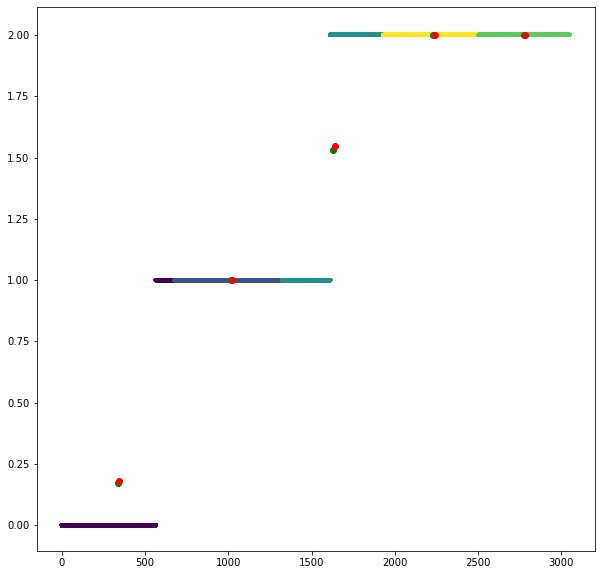

old_centroids: [[ 3.38814614e+02  1.73301115e-01 -1.58975396e-01  2.46335174e-01
   1.40949955e+00]
 [ 1.01426241e+03  1.00000000e+00 -9.97543307e-02  1.35697702e-01
   2.91066678e+00]
 [ 1.62906810e+03  1.53162978e+00 -1.34153786e-01  5.89916756e-02
   1.37368575e+00]
 [ 2.77812454e+03  2.00000000e+00  3.35098042e-01 -3.12854702e-01
   1.55042810e-01]
 [ 2.23130676e+03  2.00000000e+00  1.45462657e-01 -2.33675633e-01
   9.60076932e-02]]
centroids: [[ 3.35184754e+02  1.64498338e-01 -1.62035865e-01  2.49778836e-01
   1.39315726e+00]
 [ 1.00466553e+03  1.00000000e+00 -9.30911097e-02  1.27015425e-01
   2.91241951e+00]
 [ 1.61996071e+03  1.51641523e+00 -1.37688991e-01  6.93334323e-02
   1.41652344e+00]
 [ 2.77503295e+03  2.00000000e+00  3.41963858e-01 -3.13725834e-01
   1.58086860e-01]
 [ 2.22420962e+03  2.00000000e+00  1.32864767e-01 -2.31094565e-01
   9.10256826e-02]]
cluster distances: 32.523065718303826


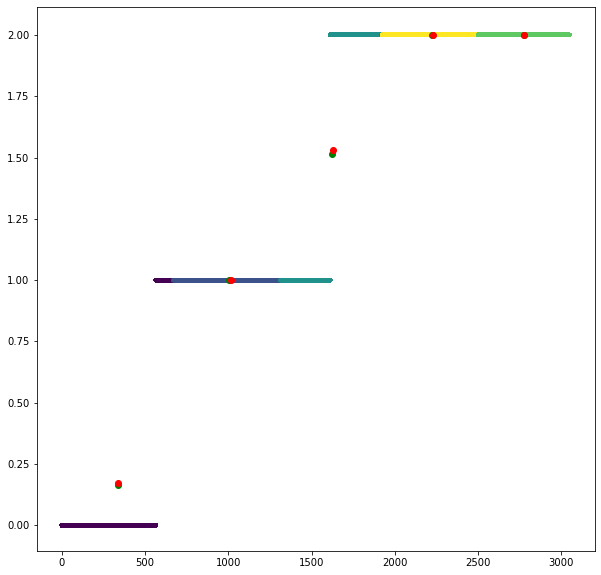

old_centroids: [[ 3.35184754e+02  1.64498338e-01 -1.62035865e-01  2.49778836e-01
   1.39315726e+00]
 [ 1.00466553e+03  1.00000000e+00 -9.30911097e-02  1.27015425e-01
   2.91241951e+00]
 [ 1.61996071e+03  1.51641523e+00 -1.37688991e-01  6.93334323e-02
   1.41652344e+00]
 [ 2.77503295e+03  2.00000000e+00  3.41963858e-01 -3.13725834e-01
   1.58086860e-01]
 [ 2.22420962e+03  2.00000000e+00  1.32864767e-01 -2.31094565e-01
   9.10256826e-02]]
centroids: [[ 3.31860353e+02  1.56267937e-01 -1.67643317e-01  2.54981771e-01
   1.37714792e+00]
 [ 9.96328683e+02  1.00000000e+00 -8.51069506e-02  1.16114259e-01
   2.91486420e+00]
 [ 1.61224814e+03  1.50366701e+00 -1.40278854e-01  7.76974990e-02
   1.45135384e+00]
 [ 2.77285436e+03  2.00000000e+00  3.38800722e-01 -3.12776985e-01
   1.56842015e-01]
 [ 2.21854632e+03  2.00000000e+00  1.31894313e-01 -2.28940346e-01
   9.17700007e-02]]
cluster distances: 27.21586805295543


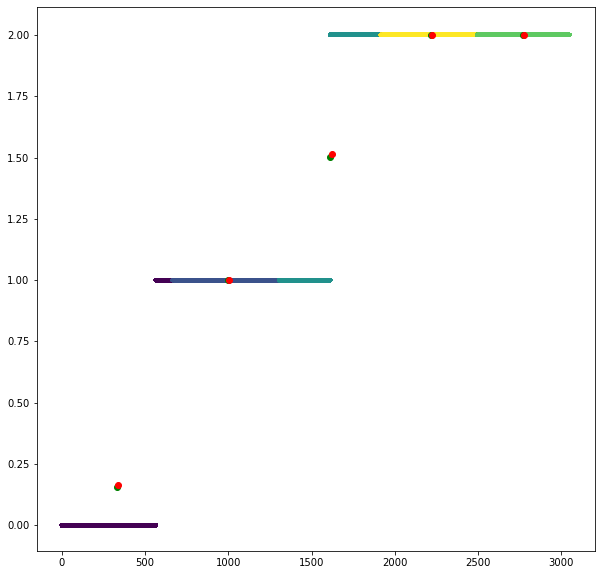

old_centroids: [[ 3.31860353e+02  1.56267937e-01 -1.67643317e-01  2.54981771e-01
   1.37714792e+00]
 [ 9.96328683e+02  1.00000000e+00 -8.51069506e-02  1.16114259e-01
   2.91486420e+00]
 [ 1.61224814e+03  1.50366701e+00 -1.40278854e-01  7.76974990e-02
   1.45135384e+00]
 [ 2.77285436e+03  2.00000000e+00  3.38800722e-01 -3.12776985e-01
   1.56842015e-01]
 [ 2.21854632e+03  2.00000000e+00  1.31894313e-01 -2.28940346e-01
   9.17700007e-02]]
centroids: [[ 3.29526275e+02  1.50395173e-01 -1.67919561e-01  2.56396117e-01
   1.36653932e+00]
 [ 9.89697523e+02  1.00000000e+00 -8.32988175e-02  1.12558921e-01
   2.91521451e+00]
 [ 1.60605424e+03  1.49349197e+00 -1.41760887e-01  8.31997937e-02
   1.48028786e+00]
 [ 2.77093101e+03  2.00000000e+00  3.36304987e-01 -3.11175119e-01
   1.56309884e-01]
 [ 2.21407733e+03  2.00000000e+00  1.30811204e-01 -2.29713087e-01
   9.13770706e-02]]
cluster distances: 21.55159400279097


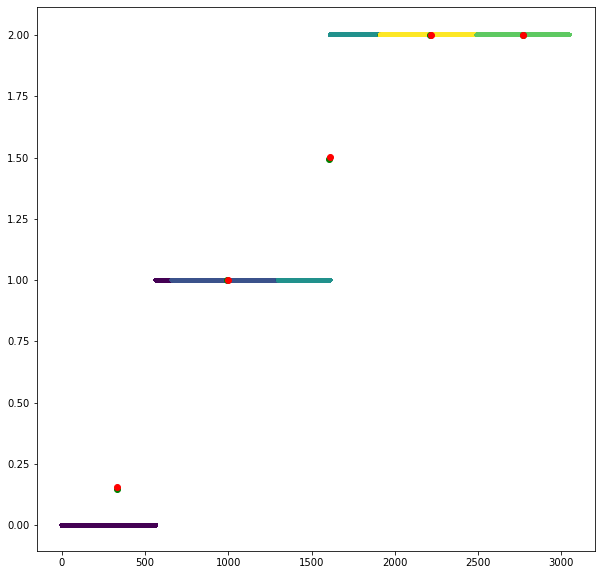

old_centroids: [[ 3.29526275e+02  1.50395173e-01 -1.67919561e-01  2.56396117e-01
   1.36653932e+00]
 [ 9.89697523e+02  1.00000000e+00 -8.32988175e-02  1.12558921e-01
   2.91521451e+00]
 [ 1.60605424e+03  1.49349197e+00 -1.41760887e-01  8.31997937e-02
   1.48028786e+00]
 [ 2.77093101e+03  2.00000000e+00  3.36304987e-01 -3.11175119e-01
   1.56309884e-01]
 [ 2.21407733e+03  2.00000000e+00  1.30811204e-01 -2.29713087e-01
   9.13770706e-02]]
centroids: [[ 3.26907325e+02  1.43698472e-01 -1.68214814e-01  2.58208797e-01
   1.35401465e+00]
 [ 9.83067516e+02  1.00000000e+00 -8.08549697e-02  1.03550807e-01
   2.91732847e+00]
 [ 1.59998176e+03  1.48358827e+00 -1.43532060e-01  9.12486890e-02
   1.50635752e+00]
 [ 2.76940493e+03  2.00000000e+00  3.33758475e-01 -3.10540420e-01
   1.55455276e-01]
 [ 2.20978346e+03  2.00000000e+00  1.29423064e-01 -2.26622749e-01
   9.22897186e-02]]
cluster distances: 21.141506579901606


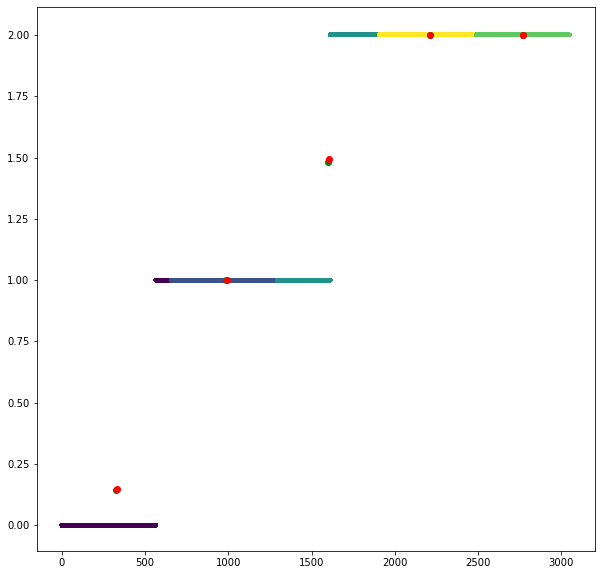

old_centroids: [[ 3.26907325e+02  1.43698472e-01 -1.68214814e-01  2.58208797e-01
   1.35401465e+00]
 [ 9.83067516e+02  1.00000000e+00 -8.08549697e-02  1.03550807e-01
   2.91732847e+00]
 [ 1.59998176e+03  1.48358827e+00 -1.43532060e-01  9.12486890e-02
   1.50635752e+00]
 [ 2.76940493e+03  2.00000000e+00  3.33758475e-01 -3.10540420e-01
   1.55455276e-01]
 [ 2.20978346e+03  2.00000000e+00  1.29423064e-01 -2.26622749e-01
   9.22897186e-02]]
centroids: [[ 3.24535391e+02  1.37540468e-01 -1.69829552e-01  2.60033977e-01
   1.34249002e+00]
 [ 9.76882909e+02  1.00000000e+00 -7.78785662e-02  1.00658848e-01
   2.91792748e+00]
 [ 1.59352071e+03  1.47307818e+00 -1.46023738e-01  9.53738809e-02
   1.53627516e+00]
 [ 2.76767607e+03  2.00000000e+00  3.30747453e-01 -3.09839892e-01
   1.54490203e-01]
 [ 2.20462174e+03  2.00000000e+00  1.29682915e-01 -2.25474439e-01
   9.23606958e-02]]
cluster distances: 21.908304359342196


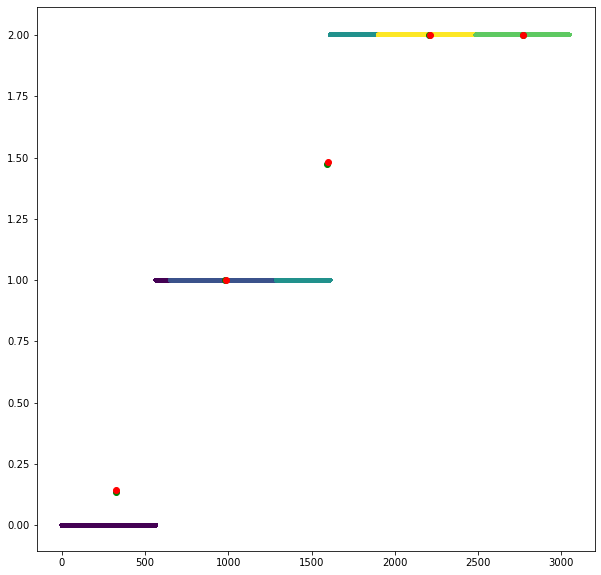

old_centroids: [[ 3.24535391e+02  1.37540468e-01 -1.69829552e-01  2.60033977e-01
   1.34249002e+00]
 [ 9.76882909e+02  1.00000000e+00 -7.78785662e-02  1.00658848e-01
   2.91792748e+00]
 [ 1.59352071e+03  1.47307818e+00 -1.46023738e-01  9.53738809e-02
   1.53627516e+00]
 [ 2.76767607e+03  2.00000000e+00  3.30747453e-01 -3.09839892e-01
   1.54490203e-01]
 [ 2.20462174e+03  2.00000000e+00  1.29682915e-01 -2.25474439e-01
   9.23606958e-02]]
centroids: [[ 3.22523652e+02  1.32248322e-01 -1.70583258e-01  2.61799190e-01
   1.33261804e+00]
 [ 9.71816024e+02  1.00000000e+00 -7.58675627e-02  9.62048138e-02
   2.91912270e+00]
 [ 1.58862682e+03  1.46516519e+00 -1.47329706e-01  9.90010135e-02
   1.55781301e+00]
 [ 2.76608299e+03  2.00000000e+00  3.30457274e-01 -3.09957783e-01
   1.53809477e-01]
 [ 2.20057722e+03  2.00000000e+00  1.26840264e-01 -2.22423978e-01
   9.26742759e-02]]
cluster distances: 17.610198598805077


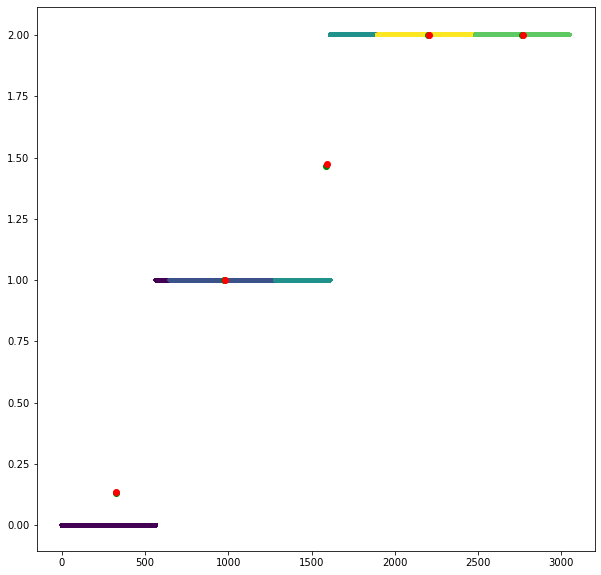

old_centroids: [[ 3.22523652e+02  1.32248322e-01 -1.70583258e-01  2.61799190e-01
   1.33261804e+00]
 [ 9.71816024e+02  1.00000000e+00 -7.58675627e-02  9.62048138e-02
   2.91912270e+00]
 [ 1.58862682e+03  1.46516519e+00 -1.47329706e-01  9.90010135e-02
   1.55781301e+00]
 [ 2.76608299e+03  2.00000000e+00  3.30457274e-01 -3.09957783e-01
   1.53809477e-01]
 [ 2.20057722e+03  2.00000000e+00  1.26840264e-01 -2.22423978e-01
   9.26742759e-02]]
centroids: [[ 3.20649881e+02  1.27267821e-01 -1.70595053e-01  2.62939589e-01
   1.32347412e+00]
 [ 9.67961035e+02  1.00000000e+00 -7.50310160e-02  9.33364008e-02
   2.91976805e+00]
 [ 1.58482490e+03  1.45894676e+00 -1.47683345e-01  1.00984443e-01
   1.57429191e+00]
 [ 2.76509368e+03  2.00000000e+00  3.28513732e-01 -3.09260353e-01
   1.53268008e-01]
 [ 2.19725932e+03  2.00000000e+00  1.25337896e-01 -2.19716826e-01
   9.35715398e-02]]
cluster distances: 13.837960980132644


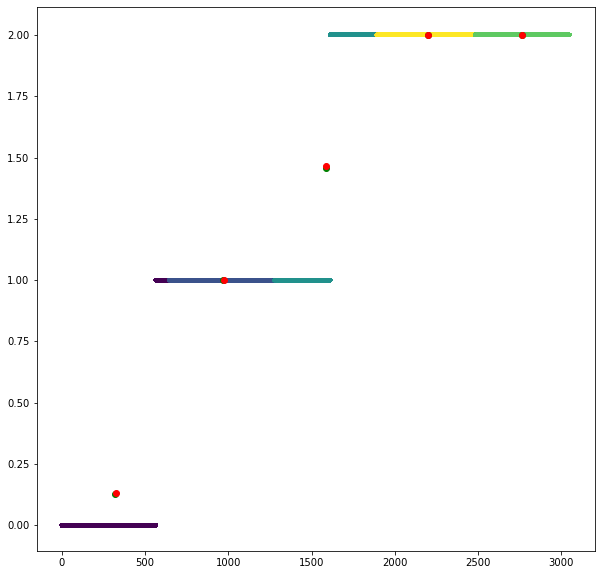

old_centroids: [[ 3.20649881e+02  1.27267821e-01 -1.70595053e-01  2.62939589e-01
   1.32347412e+00]
 [ 9.67961035e+02  1.00000000e+00 -7.50310160e-02  9.33364008e-02
   2.91976805e+00]
 [ 1.58482490e+03  1.45894676e+00 -1.47683345e-01  1.00984443e-01
   1.57429191e+00]
 [ 2.76509368e+03  2.00000000e+00  3.28513732e-01 -3.09260353e-01
   1.53268008e-01]
 [ 2.19725932e+03  2.00000000e+00  1.25337896e-01 -2.19716826e-01
   9.35715398e-02]]
centroids: [[ 3.18878047e+02  1.22514991e-01 -1.74004414e-01  2.61983223e-01
   1.31510220e+00]
 [ 9.63821472e+02  1.00000000e+00 -7.06310648e-02  9.47413602e-02
   2.91967761e+00]
 [ 1.58114190e+03  1.45304286e+00 -1.49360107e-01  1.03140784e-01
   1.59124925e+00]
 [ 2.76402918e+03  2.00000000e+00  3.29193221e-01 -3.09900683e-01
   1.52703859e-01]
 [ 2.19443767e+03  2.00000000e+00  1.23340554e-01 -2.18850699e-01
   9.34492606e-02]]
cluster distances: 13.480622814602025


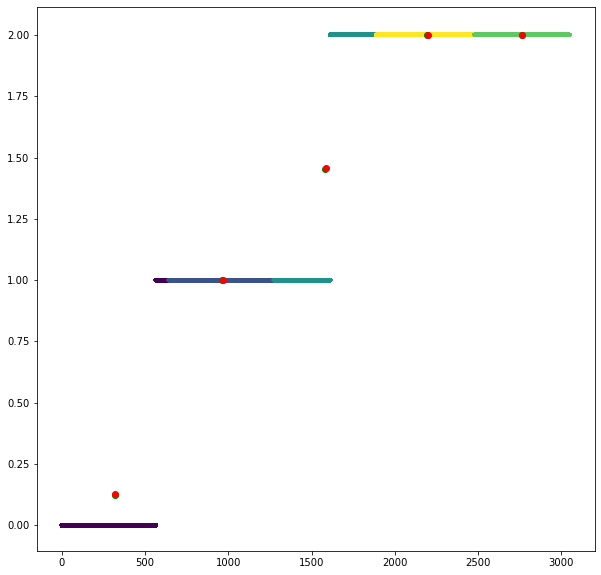

old_centroids: [[ 3.18878047e+02  1.22514991e-01 -1.74004414e-01  2.61983223e-01
   1.31510220e+00]
 [ 9.63821472e+02  1.00000000e+00 -7.06310648e-02  9.47413602e-02
   2.91967761e+00]
 [ 1.58114190e+03  1.45304286e+00 -1.49360107e-01  1.03140784e-01
   1.59124925e+00]
 [ 2.76402918e+03  2.00000000e+00  3.29193221e-01 -3.09900683e-01
   1.52703859e-01]
 [ 2.19443767e+03  2.00000000e+00  1.23340554e-01 -2.18850699e-01
   9.34492606e-02]]
centroids: [[ 3.17648677e+02  1.19187963e-01 -1.74213189e-01  2.62100988e-01
   1.30910875e+00]
 [ 9.60767254e+02  1.00000000e+00 -6.95149945e-02  9.42541362e-02
   2.91987514e+00]
 [ 1.57718756e+03  1.44652862e+00 -1.51363535e-01  1.06792812e-01
   1.60997853e+00]
 [ 2.76276459e+03  2.00000000e+00  3.27332697e-01 -3.09681856e-01
   1.52039189e-01]
 [ 2.19054260e+03  2.00000000e+00  1.23343078e-01 -2.19063570e-01
   9.30578591e-02]]
cluster distances: 13.39767616975368


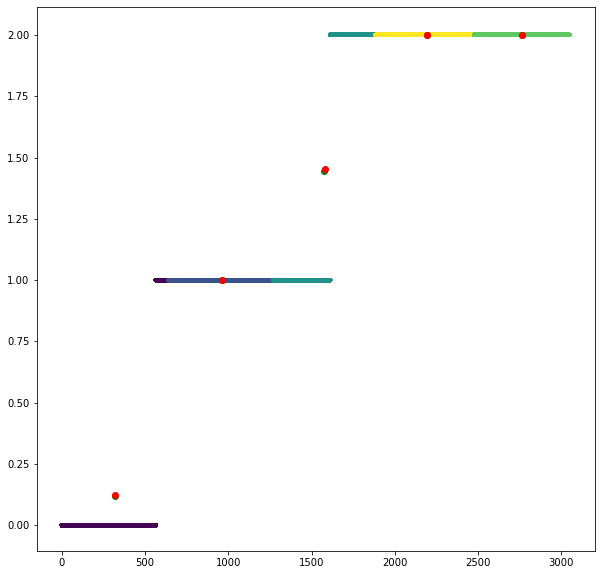

old_centroids: [[ 3.17648677e+02  1.19187963e-01 -1.74213189e-01  2.62100988e-01
   1.30910875e+00]
 [ 9.60767254e+02  1.00000000e+00 -6.95149945e-02  9.42541362e-02
   2.91987514e+00]
 [ 1.57718756e+03  1.44652862e+00 -1.51363535e-01  1.06792812e-01
   1.60997853e+00]
 [ 2.76276459e+03  2.00000000e+00  3.27332697e-01 -3.09681856e-01
   1.52039189e-01]
 [ 2.19054260e+03  2.00000000e+00  1.23343078e-01 -2.19063570e-01
   9.30578591e-02]]
centroids: [[ 3.16682388e+02  1.16551310e-01 -1.74444350e-01  2.63495812e-01
   1.30405365e+00]
 [ 9.57635058e+02  1.00000000e+00 -6.87087276e-02  9.32259486e-02
   2.92012866e+00]
 [ 1.57338786e+03  1.44039381e+00 -1.51974715e-01  1.07668511e-01
   1.62782102e+00]
 [ 2.76210888e+03  2.00000000e+00  3.26238239e-01 -3.09496417e-01
   1.51689512e-01]
 [ 2.18783394e+03  2.00000000e+00  1.22479607e-01 -2.17860671e-01
   9.27274460e-02]]
cluster distances: 11.262608043833918


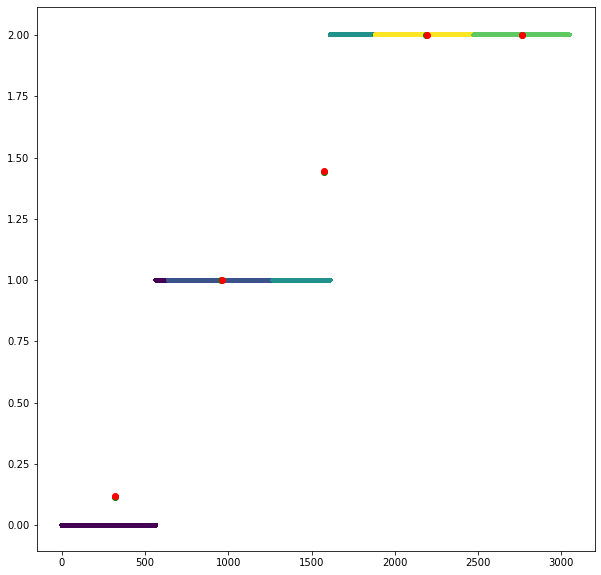

old_centroids: [[ 3.16682388e+02  1.16551310e-01 -1.74444350e-01  2.63495812e-01
   1.30405365e+00]
 [ 9.57635058e+02  1.00000000e+00 -6.87087276e-02  9.32259486e-02
   2.92012866e+00]
 [ 1.57338786e+03  1.44039381e+00 -1.51974715e-01  1.07668511e-01
   1.62782102e+00]
 [ 2.76210888e+03  2.00000000e+00  3.26238239e-01 -3.09496417e-01
   1.51689512e-01]
 [ 2.18783394e+03  2.00000000e+00  1.22479607e-01 -2.17860671e-01
   9.27274460e-02]]
centroids: [[ 3.16005510e+02  1.14693561e-01 -1.74378657e-01  2.63640137e-01
   1.30068258e+00]
 [ 9.55412548e+02  1.00000000e+00 -6.81719318e-02  9.37604784e-02
   2.91997354e+00]
 [ 1.57032704e+03  1.43538291e+00 -1.54551479e-01  1.09797630e-01
   1.64225901e+00]
 [ 2.76100473e+03  2.00000000e+00  3.41174674e-01 -3.09553733e-01
   1.57517962e-01]
 [ 2.18485153e+03  2.00000000e+00  1.07380844e-01 -2.18339495e-01
   8.63864282e-02]]
cluster distances: 10.046981890707778


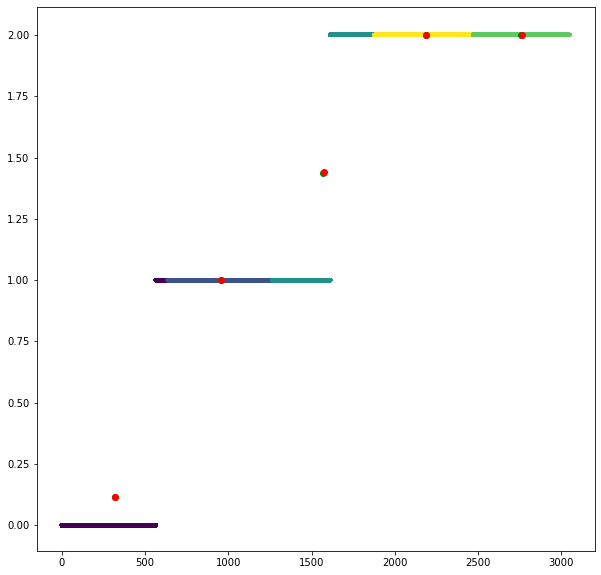

old_centroids: [[ 3.16005510e+02  1.14693561e-01 -1.74378657e-01  2.63640137e-01
   1.30068258e+00]
 [ 9.55412548e+02  1.00000000e+00 -6.81719318e-02  9.37604784e-02
   2.91997354e+00]
 [ 1.57032704e+03  1.43538291e+00 -1.54551479e-01  1.09797630e-01
   1.64225901e+00]
 [ 2.76100473e+03  2.00000000e+00  3.41174674e-01 -3.09553733e-01
   1.57517962e-01]
 [ 2.18485153e+03  2.00000000e+00  1.07380844e-01 -2.18339495e-01
   8.63864282e-02]]
centroids: [[ 3.14767158e+02  1.11272782e-01 -1.74937924e-01  2.65124031e-01
   1.29433490e+00]
 [ 9.52882616e+02  1.00000000e+00 -6.69925901e-02  9.16065334e-02
   2.92061711e+00]
 [ 1.56752609e+03  1.43073888e+00 -1.55385533e-01  1.11352481e-01
   1.65463086e+00]
 [ 2.75978535e+03  2.00000000e+00  3.39523585e-01 -3.09826464e-01
   1.56862936e-01]
 [ 2.18175936e+03  2.00000000e+00  1.06686179e-01 -2.16129135e-01
   8.69775491e-02]]
cluster distances: 10.88085369676816


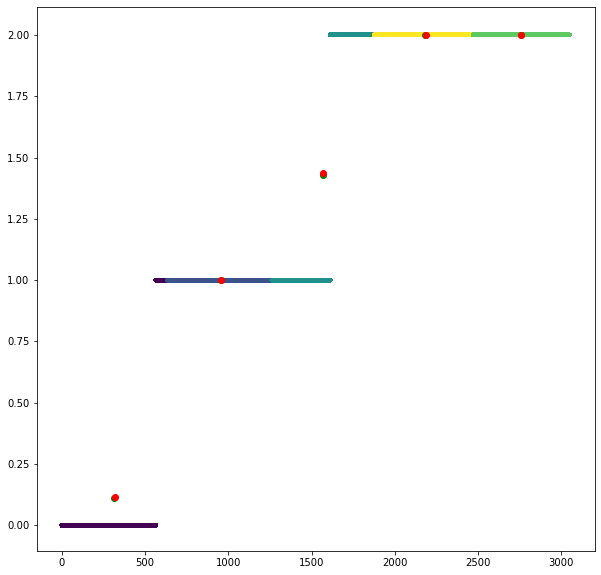

old_centroids: [[ 3.14767158e+02  1.11272782e-01 -1.74937924e-01  2.65124031e-01
   1.29433490e+00]
 [ 9.52882616e+02  1.00000000e+00 -6.69925901e-02  9.16065334e-02
   2.92061711e+00]
 [ 1.56752609e+03  1.43073888e+00 -1.55385533e-01  1.11352481e-01
   1.65463086e+00]
 [ 2.75978535e+03  2.00000000e+00  3.39523585e-01 -3.09826464e-01
   1.56862936e-01]
 [ 2.18175936e+03  2.00000000e+00  1.06686179e-01 -2.16129135e-01
   8.69775491e-02]]
centroids: [[ 3.13529282e+02  1.07831942e-01 -1.76281374e-01  2.65588698e-01
   1.28811448e+00]
 [ 9.50511598e+02  1.00000000e+00 -6.51234365e-02  8.91483765e-02
   2.92145956e+00]
 [ 1.56545411e+03  1.42736577e+00 -1.56293922e-01  1.14429197e-01
   1.66316740e+00]
 [ 2.75882755e+03  2.00000000e+00  3.37831762e-01 -3.09352781e-01
   1.56341526e-01]
 [ 2.17959245e+03  2.00000000e+00  1.06996302e-01 -2.15708670e-01
   8.74366164e-02]]
cluster distances: 8.80561342579309


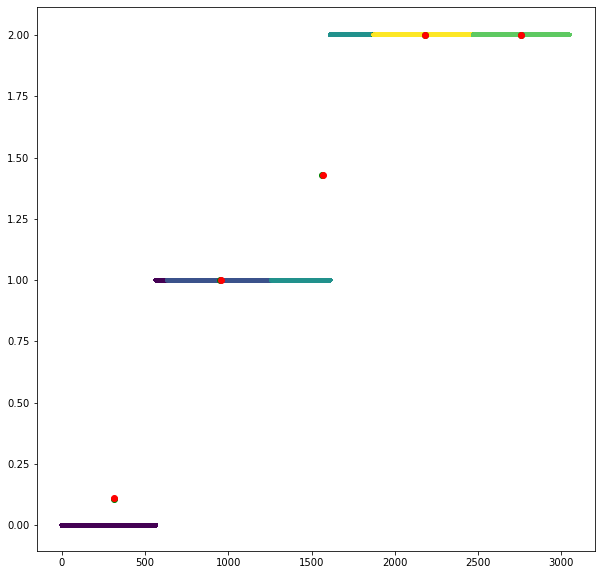

old_centroids: [[ 3.13529282e+02  1.07831942e-01 -1.76281374e-01  2.65588698e-01
   1.28811448e+00]
 [ 9.50511598e+02  1.00000000e+00 -6.51234365e-02  8.91483765e-02
   2.92145956e+00]
 [ 1.56545411e+03  1.42736577e+00 -1.56293922e-01  1.14429197e-01
   1.66316740e+00]
 [ 2.75882755e+03  2.00000000e+00  3.37831762e-01 -3.09352781e-01
   1.56341526e-01]
 [ 2.17959245e+03  2.00000000e+00  1.06996302e-01 -2.15708670e-01
   8.74366164e-02]]
centroids: [[ 3.13119867e+02  1.06688590e-01 -1.77009633e-01  2.66506350e-01
   1.28592062e+00]
 [ 9.48578399e+02  1.00000000e+00 -6.32080962e-02  8.73367961e-02
   2.92180993e+00]
 [ 1.56331880e+03  1.42405975e+00 -1.57268363e-01  1.16215970e-01
   1.67261571e+00]
 [ 2.75821400e+03  2.00000000e+00  3.36730631e-01 -3.09378661e-01
   1.56009412e-01]
 [ 2.17815041e+03  2.00000000e+00  1.07103829e-01 -2.15601887e-01
   8.73938660e-02]]
cluster distances: 6.53355152713227


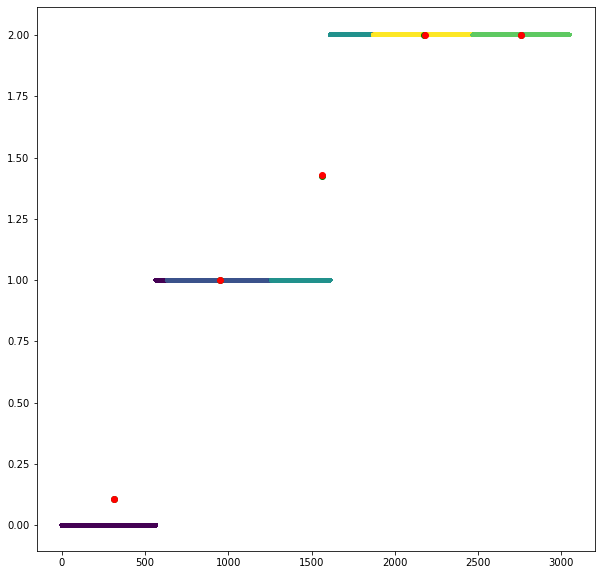

old_centroids: [[ 3.13119867e+02  1.06688590e-01 -1.77009633e-01  2.66506350e-01
   1.28592062e+00]
 [ 9.48578399e+02  1.00000000e+00 -6.32080962e-02  8.73367961e-02
   2.92180993e+00]
 [ 1.56331880e+03  1.42405975e+00 -1.57268363e-01  1.16215970e-01
   1.67261571e+00]
 [ 2.75821400e+03  2.00000000e+00  3.36730631e-01 -3.09378661e-01
   1.56009412e-01]
 [ 2.17815041e+03  2.00000000e+00  1.07103829e-01 -2.15601887e-01
   8.73938660e-02]]
centroids: [[ 3.11910998e+02  1.03296504e-01 -1.76912509e-01  2.68041095e-01
   1.27941191e+00]
 [ 9.46280652e+02  1.00000000e+00 -6.32515437e-02  8.56490801e-02
   2.92231805e+00]
 [ 1.56152036e+03  1.42118200e+00 -1.57456168e-01  1.17283250e-01
   1.68060661e+00]
 [ 2.75770079e+03  2.00000000e+00  3.38527391e-01 -3.09678472e-01
   1.56774685e-01]
 [ 2.17670124e+03  2.00000000e+00  1.04074538e-01 -2.14587838e-01
   8.64939204e-02]]
cluster distances: 7.267492037524141


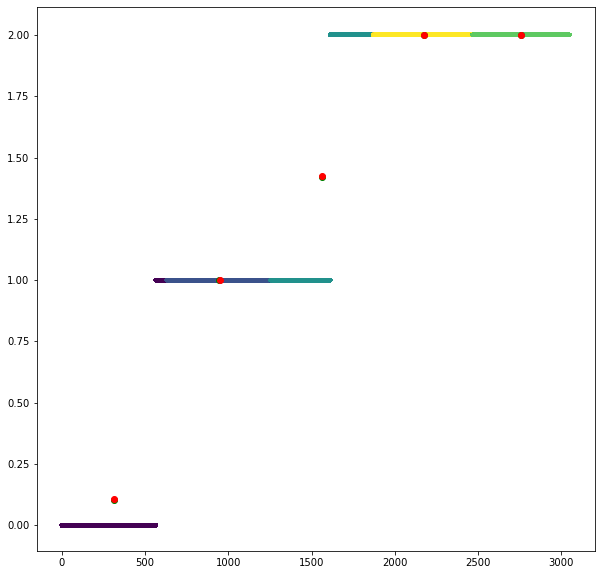

old_centroids: [[ 3.11910998e+02  1.03296504e-01 -1.76912509e-01  2.68041095e-01
   1.27941191e+00]
 [ 9.46280652e+02  1.00000000e+00 -6.32515437e-02  8.56490801e-02
   2.92231805e+00]
 [ 1.56152036e+03  1.42118200e+00 -1.57456168e-01  1.17283250e-01
   1.68060661e+00]
 [ 2.75770079e+03  2.00000000e+00  3.38527391e-01 -3.09678472e-01
   1.56774685e-01]
 [ 2.17670124e+03  2.00000000e+00  1.04074538e-01 -2.14587838e-01
   8.64939204e-02]]
centroids: [[ 3.11283324e+02  1.01527070e-01 -1.76885373e-01  2.67842331e-01
   1.27625069e+00]
 [ 9.44430960e+02  1.00000000e+00 -6.27756848e-02  8.45412224e-02
   2.92262453e+00]
 [ 1.55982529e+03  1.41857256e+00 -1.57662743e-01  1.19449057e-01
   1.68788428e+00]
 [ 2.75708848e+03  2.00000000e+00  3.37178007e-01 -3.06804381e-01
   1.57319034e-01]
 [ 2.17542614e+03  2.00000000e+00  1.04235416e-01 -2.17420357e-01
   8.56030103e-02]]
cluster distances: 6.059892427274233


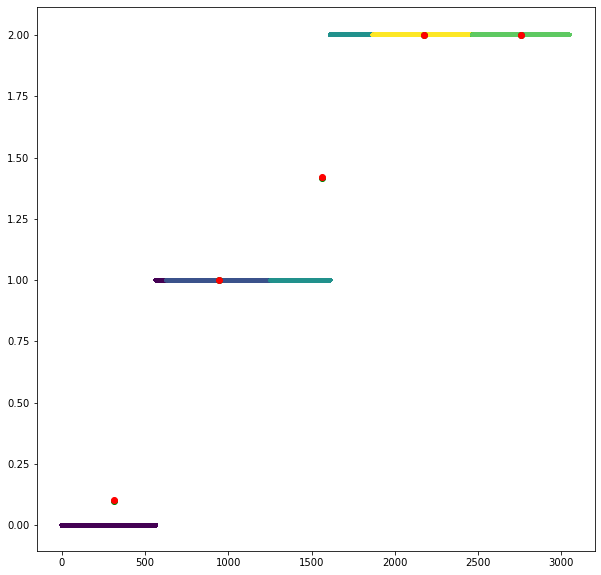

old_centroids: [[ 3.11283324e+02  1.01527070e-01 -1.76885373e-01  2.67842331e-01
   1.27625069e+00]
 [ 9.44430960e+02  1.00000000e+00 -6.27756848e-02  8.45412224e-02
   2.92262453e+00]
 [ 1.55982529e+03  1.41857256e+00 -1.57662743e-01  1.19449057e-01
   1.68788428e+00]
 [ 2.75708848e+03  2.00000000e+00  3.37178007e-01 -3.06804381e-01
   1.57319034e-01]
 [ 2.17542614e+03  2.00000000e+00  1.04235416e-01 -2.17420357e-01
   8.56030103e-02]]
centroids: [[ 3.10257336e+02  9.86221692e-02 -1.78119466e-01  2.69799254e-01
   1.27070982e+00]
 [ 9.43105609e+02  1.00000000e+00 -6.16326552e-02  8.28159395e-02
   2.92304358e+00]
 [ 1.55843476e+03  1.41608799e+00 -1.57803869e-01  1.21256002e-01
   1.69492868e+00]
 [ 2.75645664e+03  2.00000000e+00  3.36028455e-01 -3.06921807e-01
   1.56979592e-01]
 [ 2.17348594e+03  2.00000000e+00  1.03770439e-01 -2.17441426e-01
   8.54306465e-02]]
cluster distances: 6.313944065530431


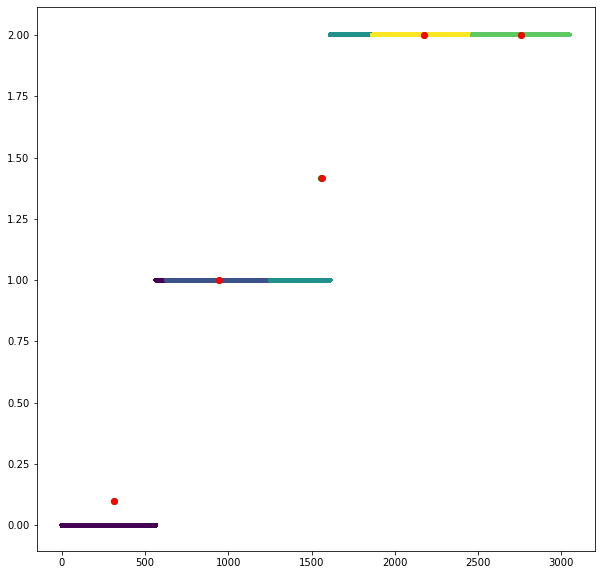

old_centroids: [[ 3.10257336e+02  9.86221692e-02 -1.78119466e-01  2.69799254e-01
   1.27070982e+00]
 [ 9.43105609e+02  1.00000000e+00 -6.16326552e-02  8.28159395e-02
   2.92304358e+00]
 [ 1.55843476e+03  1.41608799e+00 -1.57803869e-01  1.21256002e-01
   1.69492868e+00]
 [ 2.75645664e+03  2.00000000e+00  3.36028455e-01 -3.06921807e-01
   1.56979592e-01]
 [ 2.17348594e+03  2.00000000e+00  1.03770439e-01 -2.17441426e-01
   8.54306465e-02]]
centroids: [[ 3.09733979e+02  9.71328150e-02 -1.78073184e-01  2.70882404e-01
   1.26785176e+00]
 [ 9.41365205e+02  1.00000000e+00 -6.09021878e-02  8.01679312e-02
   2.92366373e+00]
 [ 1.55669141e+03  1.41339416e+00 -1.58199787e-01  1.23120173e-01
   1.70236124e+00]
 [ 2.75522502e+03  2.00000000e+00  3.34598620e-01 -3.05738714e-01
   1.56481447e-01]
 [ 2.17151071e+03  2.00000000e+00  1.03433626e-01 -2.17790254e-01
   8.54364358e-02]]
cluster distances: 7.214004826562788


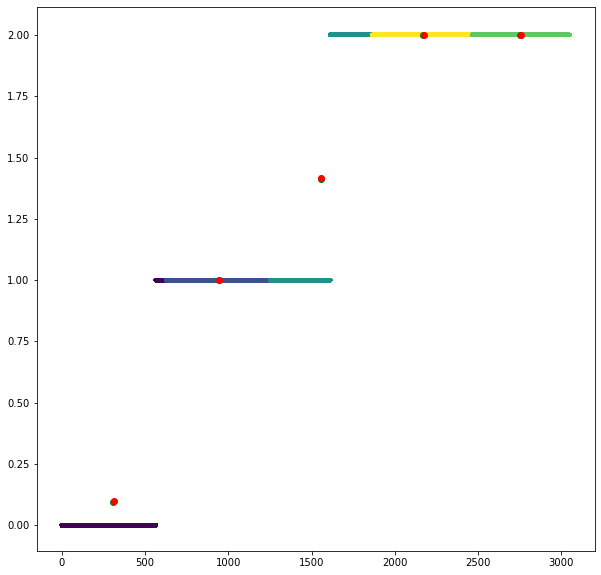

old_centroids: [[ 3.09733979e+02  9.71328150e-02 -1.78073184e-01  2.70882404e-01
   1.26785176e+00]
 [ 9.41365205e+02  1.00000000e+00 -6.09021878e-02  8.01679312e-02
   2.92366373e+00]
 [ 1.55669141e+03  1.41339416e+00 -1.58199787e-01  1.23120173e-01
   1.70236124e+00]
 [ 2.75522502e+03  2.00000000e+00  3.34598620e-01 -3.05738714e-01
   1.56481447e-01]
 [ 2.17151071e+03  2.00000000e+00  1.03433626e-01 -2.17790254e-01
   8.54364358e-02]]
centroids: [[ 3.09260892e+02  9.57822607e-02 -1.77844638e-01  2.70833832e-01
   1.26554916e+00]
 [ 9.40244675e+02  1.00000000e+00 -6.08743996e-02  8.11659732e-02
   2.92332735e+00]
 [ 1.55559062e+03  1.41163049e+00 -1.58414940e-01  1.22395412e-01
   1.70766993e+00]
 [ 2.75484658e+03  2.00000000e+00  3.33897992e-01 -3.05853182e-01
   1.56287688e-01]
 [ 2.17054167e+03  2.00000000e+00  1.03336679e-01 -2.16886009e-01
   8.53800688e-02]]
cluster distances: 4.041913321936187


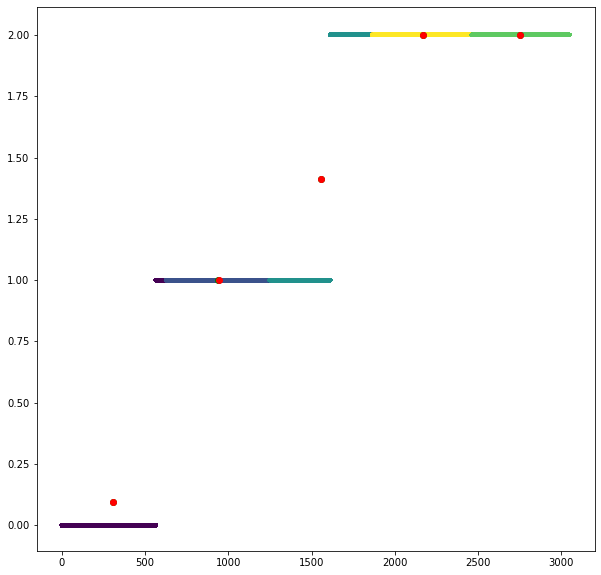

old_centroids: [[ 3.09260892e+02  9.57822607e-02 -1.77844638e-01  2.70833832e-01
   1.26554916e+00]
 [ 9.40244675e+02  1.00000000e+00 -6.08743996e-02  8.11659732e-02
   2.92332735e+00]
 [ 1.55559062e+03  1.41163049e+00 -1.58414940e-01  1.22395412e-01
   1.70766993e+00]
 [ 2.75484658e+03  2.00000000e+00  3.33897992e-01 -3.05853182e-01
   1.56287688e-01]
 [ 2.17054167e+03  2.00000000e+00  1.03336679e-01 -2.16886009e-01
   8.53800688e-02]]
centroids: [[ 3.08642653e+02  9.40117381e-02 -1.77604987e-01  2.71683578e-01
   1.26224366e+00]
 [ 9.38750220e+02  1.00000000e+00 -6.06463772e-02  7.71020318e-02
   2.92415408e+00]
 [ 1.55426679e+03  1.40956487e+00 -1.58597928e-01  1.24981618e-01
   1.71251663e+00]
 [ 2.75421533e+03  2.00000000e+00  3.32812347e-01 -3.05865338e-01
   1.55949645e-01]
 [ 2.16929866e+03  2.00000000e+00  1.03175387e-01 -2.15245346e-01
   8.59617210e-02]]
cluster distances: 5.310821089360653


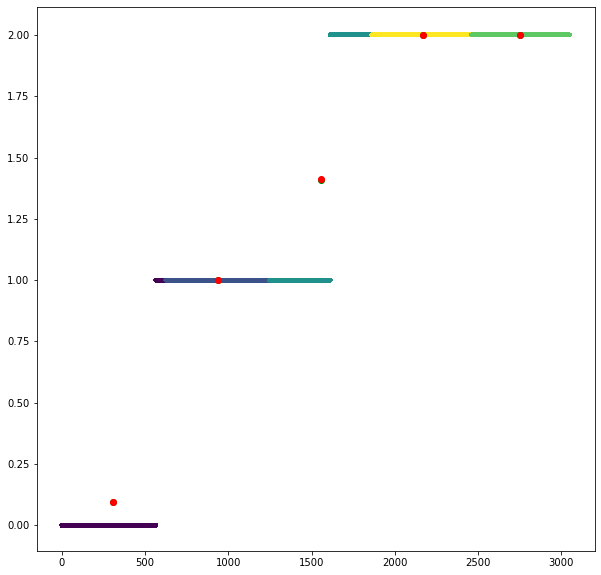

old_centroids: [[ 3.08642653e+02  9.40117381e-02 -1.77604987e-01  2.71683578e-01
   1.26224366e+00]
 [ 9.38750220e+02  1.00000000e+00 -6.06463772e-02  7.71020318e-02
   2.92415408e+00]
 [ 1.55426679e+03  1.40956487e+00 -1.58597928e-01  1.24981618e-01
   1.71251663e+00]
 [ 2.75421533e+03  2.00000000e+00  3.32812347e-01 -3.05865338e-01
   1.55949645e-01]
 [ 2.16929866e+03  2.00000000e+00  1.03175387e-01 -2.15245346e-01
   8.59617210e-02]]
centroids: [[ 3.08073190e+02  9.23757304e-02 -1.77824885e-01  2.72613890e-01
   1.25915737e+00]
 [ 9.37953866e+02  1.00000000e+00 -6.04493764e-02  7.64788928e-02
   2.92418882e+00]
 [ 1.55323068e+03  1.40769870e+00 -1.59467123e-01  1.26279775e-01
   1.71799469e+00]
 [ 2.75360412e+03  2.00000000e+00  3.32171188e-01 -3.06049243e-01
   1.55623456e-01]
 [ 2.16771242e+03  2.00000000e+00  1.03396241e-01 -2.15296723e-01
   8.58805363e-02]]
cluster distances: 4.599404873585045


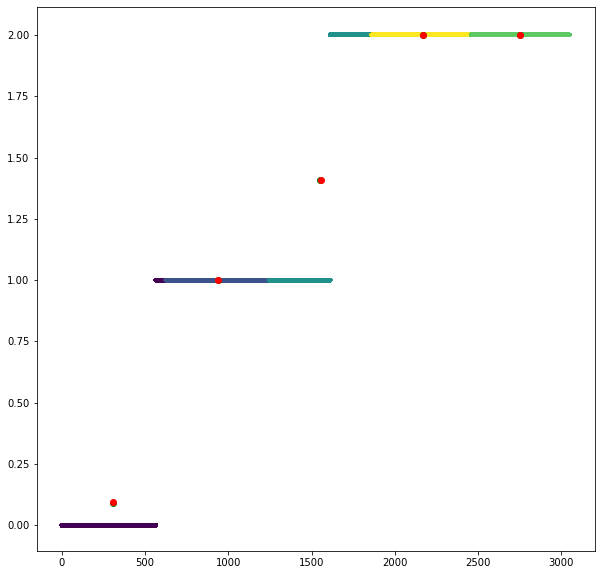

old_centroids: [[ 3.08073190e+02  9.23757304e-02 -1.77824885e-01  2.72613890e-01
   1.25915737e+00]
 [ 9.37953866e+02  1.00000000e+00 -6.04493764e-02  7.64788928e-02
   2.92418882e+00]
 [ 1.55323068e+03  1.40769870e+00 -1.59467123e-01  1.26279775e-01
   1.71799469e+00]
 [ 2.75360412e+03  2.00000000e+00  3.32171188e-01 -3.06049243e-01
   1.55623456e-01]
 [ 2.16771242e+03  2.00000000e+00  1.03396241e-01 -2.15296723e-01
   8.58805363e-02]]
centroids: [[ 3.08073190e+02  9.23757304e-02 -1.77824885e-01  2.72613890e-01
   1.25915737e+00]
 [ 9.37521023e+02  1.00000000e+00 -6.00738132e-02  7.54751848e-02
   2.92448473e+00]
 [ 1.55224777e+03  1.40605092e+00 -1.59942090e-01  1.28099044e-01
   1.72252583e+00]
 [ 2.75322344e+03  2.00000000e+00  3.32129868e-01 -3.06246964e-01
   1.55621144e-01]
 [ 2.16666023e+03  2.00000000e+00  1.02856185e-01 -2.15312569e-01
   8.56049808e-02]]
cluster distances: 2.8486298448805716


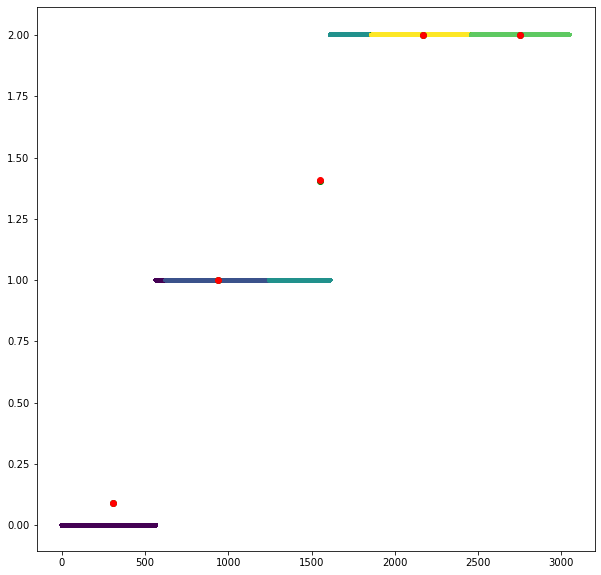

old_centroids: [[ 3.08073190e+02  9.23757304e-02 -1.77824885e-01  2.72613890e-01
   1.25915737e+00]
 [ 9.37521023e+02  1.00000000e+00 -6.00738132e-02  7.54751848e-02
   2.92448473e+00]
 [ 1.55224777e+03  1.40605092e+00 -1.59942090e-01  1.28099044e-01
   1.72252583e+00]
 [ 2.75322344e+03  2.00000000e+00  3.32129868e-01 -3.06246964e-01
   1.55621144e-01]
 [ 2.16666023e+03  2.00000000e+00  1.02856185e-01 -2.15312569e-01
   8.56049808e-02]]
centroids: [[ 3.07590288e+02  9.09840013e-02 -1.78081083e-01  2.73657528e-01
   1.25648800e+00]
 [ 9.36506856e+02  1.00000000e+00 -5.94870852e-02  7.49334879e-02
   2.92447569e+00]
 [ 1.55157017e+03  1.40504165e+00 -1.60485413e-01  1.28165676e-01
   1.72560947e+00]
 [ 2.75282573e+03  2.00000000e+00  3.31989422e-01 -3.06449120e-01
   1.55435450e-01]
 [ 2.16603344e+03  2.00000000e+00  1.02750913e-01 -2.15144897e-01
   8.56425785e-02]]
cluster distances: 3.1991977132341463


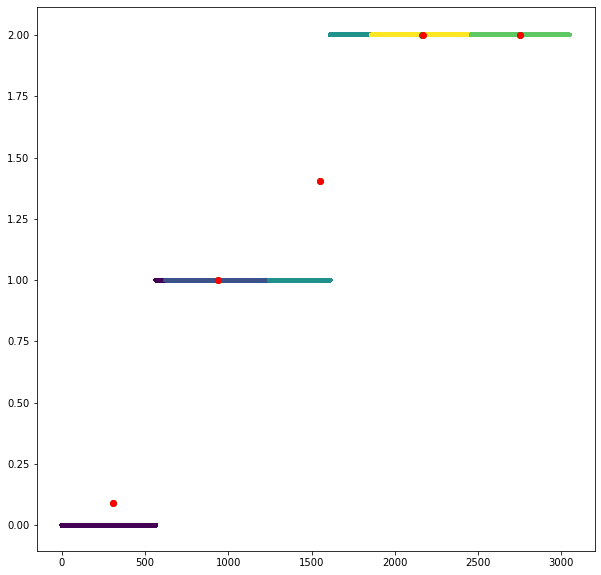

old_centroids: [[ 3.07590288e+02  9.09840013e-02 -1.78081083e-01  2.73657528e-01
   1.25648800e+00]
 [ 9.36506856e+02  1.00000000e+00 -5.94870852e-02  7.49334879e-02
   2.92447569e+00]
 [ 1.55157017e+03  1.40504165e+00 -1.60485413e-01  1.28165676e-01
   1.72560947e+00]
 [ 2.75282573e+03  2.00000000e+00  3.31989422e-01 -3.06449120e-01
   1.55435450e-01]
 [ 2.16603344e+03  2.00000000e+00  1.02750913e-01 -2.15144897e-01
   8.56425785e-02]]
centroids: [[ 3.07590288e+02  9.09840013e-02 -1.78081083e-01  2.73657528e-01
   1.25648800e+00]
 [ 9.36506856e+02  1.00000000e+00 -5.94870852e-02  7.49334879e-02
   2.92447569e+00]
 [ 1.55114271e+03  1.40421441e+00 -1.60686131e-01  1.28964439e-01
   1.72800306e+00]
 [ 2.75282573e+03  2.00000000e+00  3.31989422e-01 -3.06449120e-01
   1.55435450e-01]
 [ 2.16554424e+03  2.00000000e+00  1.02561503e-01 -2.15513213e-01
   8.55126943e-02]]
cluster distances: 0.9166620894089432


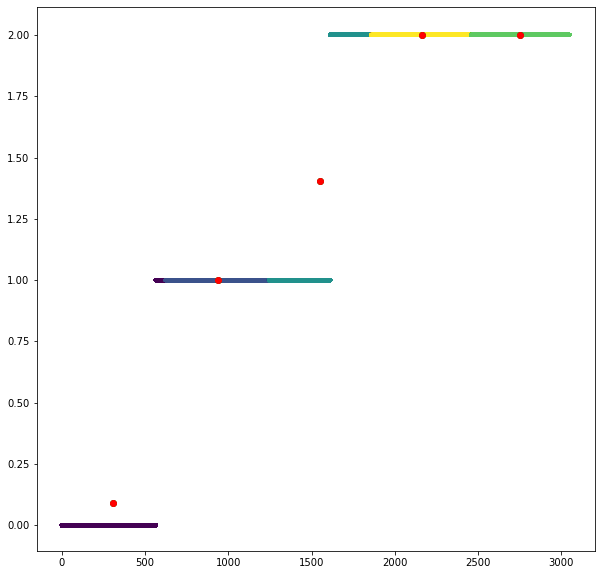

old_centroids: [[ 3.07590288e+02  9.09840013e-02 -1.78081083e-01  2.73657528e-01
   1.25648800e+00]
 [ 9.36506856e+02  1.00000000e+00 -5.94870852e-02  7.49334879e-02
   2.92447569e+00]
 [ 1.55114271e+03  1.40421441e+00 -1.60686131e-01  1.28964439e-01
   1.72800306e+00]
 [ 2.75282573e+03  2.00000000e+00  3.31989422e-01 -3.06449120e-01
   1.55435450e-01]
 [ 2.16554424e+03  2.00000000e+00  1.02561503e-01 -2.15513213e-01
   8.55126943e-02]]
centroids: [[ 3.07590288e+02  9.09840013e-02 -1.78081083e-01  2.73657528e-01
   1.25648800e+00]
 [ 9.36102642e+02  1.00000000e+00 -5.91693662e-02  7.44127578e-02
   2.92465875e+00]
 [ 1.55076191e+03  1.40371326e+00 -1.60860318e-01  1.29388574e-01
   1.72931380e+00]
 [ 2.75282573e+03  2.00000000e+00  3.31989422e-01 -3.06449120e-01
   1.55435450e-01]
 [ 2.16554424e+03  2.00000000e+00  1.02561503e-01 -2.15513213e-01
   8.55126943e-02]]
cluster distances: 0.7850143277051818


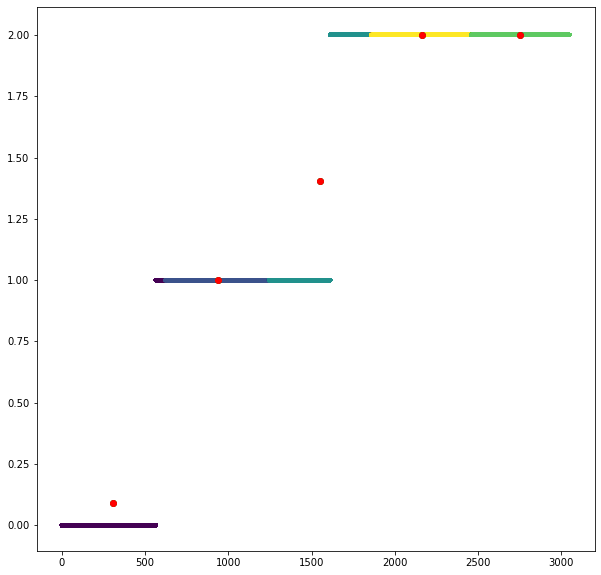

old_centroids: [[ 3.07590288e+02  9.09840013e-02 -1.78081083e-01  2.73657528e-01
   1.25648800e+00]
 [ 9.36102642e+02  1.00000000e+00 -5.91693662e-02  7.44127578e-02
   2.92465875e+00]
 [ 1.55076191e+03  1.40371326e+00 -1.60860318e-01  1.29388574e-01
   1.72931380e+00]
 [ 2.75282573e+03  2.00000000e+00  3.31989422e-01 -3.06449120e-01
   1.55435450e-01]
 [ 2.16554424e+03  2.00000000e+00  1.02561503e-01 -2.15513213e-01
   8.55126943e-02]]
centroids: [[ 3.07317718e+02  9.01959507e-02 -1.77936147e-01  2.69739525e-01
   1.25543847e+00]
 [ 9.35823727e+02  1.00000000e+00 -5.94234112e-02  7.86027933e-02
   2.92425247e+00]
 [ 1.55076191e+03  1.40371326e+00 -1.60860318e-01  1.29388574e-01
   1.72931380e+00]
 [ 2.75282573e+03  2.00000000e+00  3.31989422e-01 -3.06449120e-01
   1.55435450e-01]
 [ 2.16554424e+03  2.00000000e+00  1.02561503e-01 -2.15513213e-01
   8.55126943e-02]]
cluster distances: 0.5515477246963184


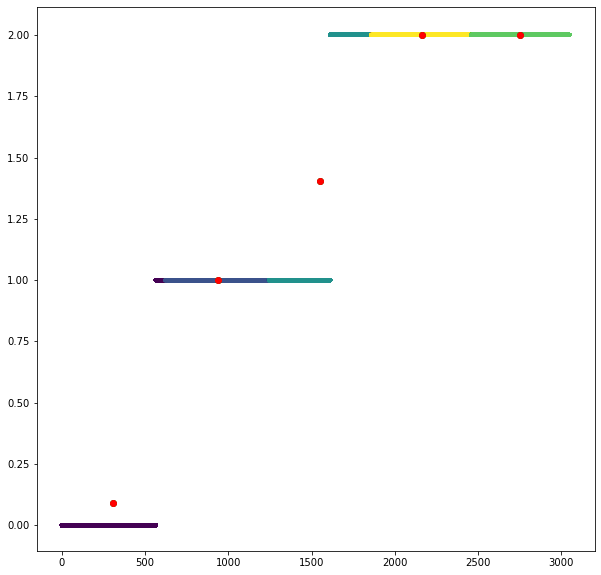

old_centroids: [[ 3.07317718e+02  9.01959507e-02 -1.77936147e-01  2.69739525e-01
   1.25543847e+00]
 [ 9.35823727e+02  1.00000000e+00 -5.94234112e-02  7.86027933e-02
   2.92425247e+00]
 [ 1.55076191e+03  1.40371326e+00 -1.60860318e-01  1.29388574e-01
   1.72931380e+00]
 [ 2.75282573e+03  2.00000000e+00  3.31989422e-01 -3.06449120e-01
   1.55435450e-01]
 [ 2.16554424e+03  2.00000000e+00  1.02561503e-01 -2.15513213e-01
   8.55126943e-02]]
centroids: [[ 3.07317718e+02  9.01959507e-02 -1.77936147e-01  2.69739525e-01
   1.25543847e+00]
 [ 9.35823727e+02  1.00000000e+00 -5.94234112e-02  7.86027933e-02
   2.92425247e+00]
 [ 1.55076191e+03  1.40371326e+00 -1.60860318e-01  1.29388574e-01
   1.72931380e+00]
 [ 2.75282573e+03  2.00000000e+00  3.31989422e-01 -3.06449120e-01
   1.55435450e-01]
 [ 2.16554424e+03  2.00000000e+00  1.02561503e-01 -2.15513213e-01
   8.55126943e-02]]
cluster distances: 0.0
Converged to a final solution


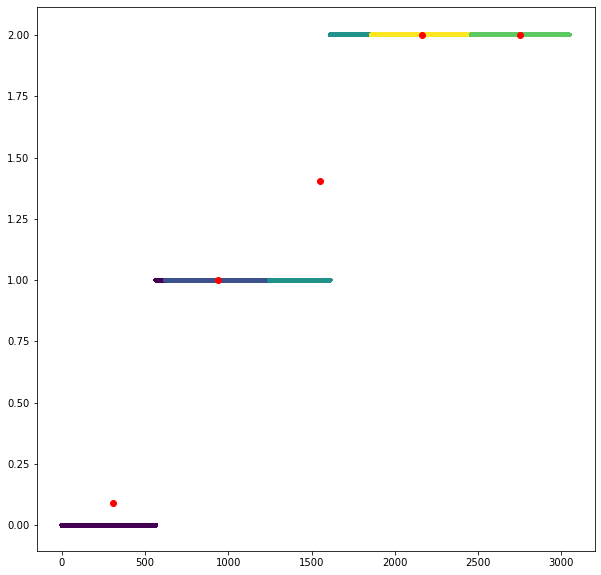

True labels


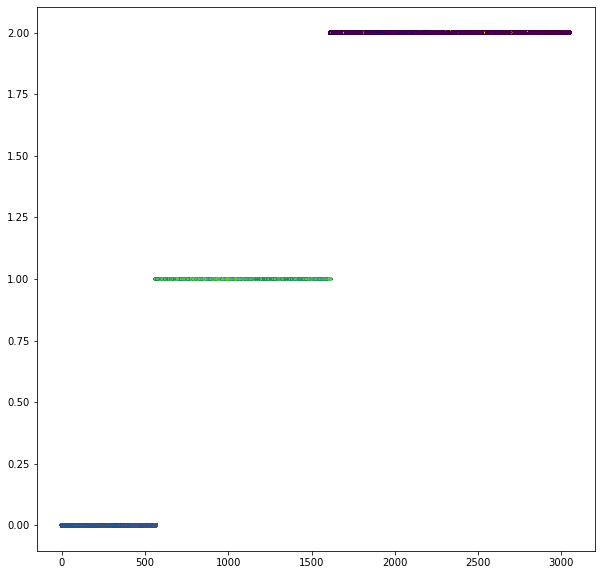

In [27]:
n_clusters = 5
epsilon = 0.0001
find_cluster_sample(X_segmentacao, kmeans.labels_, centroids, n_clusters, epsilon)

In [31]:
centroids

array([[ 3.07317718e+02,  9.01959507e-02, -1.77936147e-01,
         2.69739525e-01,  1.25543847e+00],
       [ 9.35823727e+02,  1.00000000e+00, -5.94234112e-02,
         7.86027933e-02,  2.92425247e+00],
       [ 1.55076191e+03,  1.40371326e+00, -1.60860318e-01,
         1.29388574e-01,  1.72931380e+00],
       [ 2.75282573e+03,  2.00000000e+00,  3.31989422e-01,
        -3.06449120e-01,  1.55435450e-01],
       [ 2.16554424e+03,  2.00000000e+00,  1.02561503e-01,
        -2.15513213e-01,  8.55126943e-02]])

## Caracteristicas dos Dados Segmentados

In [34]:
centroids

array([[ 3.07317718e+02,  9.01959507e-02, -1.77936147e-01,
         2.69739525e-01,  1.25543847e+00],
       [ 9.35823727e+02,  1.00000000e+00, -5.94234112e-02,
         7.86027933e-02,  2.92425247e+00],
       [ 1.55076191e+03,  1.40371326e+00, -1.60860318e-01,
         1.29388574e-01,  1.72931380e+00],
       [ 2.75282573e+03,  2.00000000e+00,  3.31989422e-01,
        -3.06449120e-01,  1.55435450e-01],
       [ 2.16554424e+03,  2.00000000e+00,  1.02561503e-01,
        -2.15513213e-01,  8.55126943e-02]])

In [39]:
colunas = ['Cluster','item', 'category', 'value_sales', 'avg_price_week']

centroid_df = pd.DataFrame(centroids, columns=colunas)

# Visualizando os centroides
print("Centroides dos Clusters:")
print(centroid_df)

# Entendendo os centroides
for i in range(len(centroids)):
    print(f"\nCluster {i+1}:")
    print("Itens Mais Vendidos:", centroid_df['item'][i])
    print("Categoria Mais Vendidas:", centroid_df['category'][i])
    print("Média de Itens Vendidos:", centroid_df['value_sales'][i])
    print("Média do Valor Vendido (k$):", centroid_df['avg_price_week'][i])

Centroides dos Clusters:
       Cluster      item  category  value_sales  avg_price_week
0   307.317718  0.090196 -0.177936     0.269740        1.255438
1   935.823727  1.000000 -0.059423     0.078603        2.924252
2  1550.761912  1.403713 -0.160860     0.129389        1.729314
3  2752.825730  2.000000  0.331989    -0.306449        0.155435
4  2165.544238  2.000000  0.102562    -0.215513        0.085513

Cluster 1:
Itens Mais Vendidos: 0.0901959506880632
Categoria Mais Vendidas: -0.17793614700703478
Média de Itens Vendidos: 0.26973952500738874
Média do Valor Vendido (k$): 1.2554384681672672

Cluster 2:
Itens Mais Vendidos: 1.0
Categoria Mais Vendidas: -0.0594234111840173
Média de Itens Vendidos: 0.07860279330026472
Média do Valor Vendido (k$): 2.924252465997743

Cluster 3:
Itens Mais Vendidos: 1.403713258610989
Categoria Mais Vendidas: -0.16086031801384224
Média de Itens Vendidos: 0.12938857360052622
Média do Valor Vendido (k$): 1.7293137980549667

Cluster 4:
Itens Mais Vendidos: 2.0

In [42]:
# Encontrando o perfil majoritário e minoritário
item_category_cluster = df['cluster'].value_counts()

perfil_majoritario = item_category_cluster.idxmax()
perfil_minoritario = item_category_cluster.idxmin()

print("Cluster Perfil Majoritário / + Dominante:", perfil_majoritario)
print("Cluster Perfil Minoritário: / - Dominante ", perfil_minoritario)

Cluster Perfil Majoritário / + Dominante: 4
Cluster Perfil Minoritário: / - Dominante  1
